## Packages

In [2]:
import os
import numpy as np
from scipy.io import loadmat
import pandas as pd
import re
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis, iqr, mode
from scipy.integrate import simps
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from collections import Counter

## Dataset Gathering

In [3]:
# Path to the Inertial folder
inertial_folder_path = '/Users/priyanshutuli/Desktop/UTD_MHAD_DNN/UTD_MHAD_Dataset/Inertial'   # Replace with the actual path

# List all files in the Inertial folder
inertial_files = [f for f in os.listdir(inertial_folder_path) if f.endswith('.mat')]

# Filter files with numeric part less than or equal to 21 (Wrist Activities range from 1 upto 21)
wrist_inertial_files = [f for f in inertial_files if int(re.search(r'\d+', f.split('_')[0]).group()) <= 21]

## Data Cleaning

In [4]:
ordered_file_names = list()
for subject_number in range(1, 9):
  subject_name = "s" + str(subject_number)
  for trial_number in range(1, 5):
    trial_name = "t" + str(trial_number)
    for activity_number in range(1, 22):
      activity_name = "a" + str(activity_number)
      file_name = "_".join([activity_name, subject_name, trial_name])
      file_name = file_name + "_inertial" + ".mat"
      ordered_file_names.append(file_name)

In [5]:
wrist_sensor_data = []
for file in ordered_file_names:
  try:
    data = loadmat(os.path.join(inertial_folder_path, file))
  except FileNotFoundError:
    print(f"File not present: {file}")
    continue
  data_df = pd.DataFrame(data["d_iner"])
  data_df["Activity_ID"] = int(file.split("_")[0].strip("a"))
  data_df["Subject_ID"] = int(file.split("_")[1].strip("s"))
  data_df["Trail_ID"] = int(file.split("_")[2].strip("t"))
  wrist_sensor_data.append(data_df)

File not present: a8_s1_t4_inertial.mat


In [6]:
wrist_sensor_data_df = pd.concat(wrist_sensor_data)
wrist_sensor_data_df.columns = ["ACC_X", "ACC_Y", "ACC_Z", "GYRO_X", "GYRO_Y", "GYRO_Z", "Activity_ID", "Subject_ID", "Trial_ID"]

In [7]:
UTD1_dataset = wrist_sensor_data_df.copy()
# Display the final dataset
print("Shape of the UTD1 Dataset:", UTD1_dataset.shape)
print("Columns of the UTD1 Dataset:", UTD1_dataset.columns)

Shape of the UTD1 Dataset: (119897, 9)
Columns of the UTD1 Dataset: Index(['ACC_X', 'ACC_Y', 'ACC_Z', 'GYRO_X', 'GYRO_Y', 'GYRO_Z', 'Activity_ID',
       'Subject_ID', 'Trial_ID'],
      dtype='object')


In [8]:
UTD1_dataset.head(200)

,ACC_X,ACC_Y,ACC_Z,GYRO_X,GYRO_Y,GYRO_Z,Activity_ID,Subject_ID,Trial_ID
0,-0.959473,-0.177734,-0.192871,5.221374,1.526718,0.152672,1,1,1
1,-0.961914,-0.153320,-0.159912,6.778626,1.954198,0.244275,1,1,1
2,-0.974609,-0.152832,-0.145996,11.267176,3.175573,1.099237,1,1,1
3,-0.941895,-0.135742,-0.127930,16.885496,4.732824,2.320611,1,1,1
4,-0.958252,-0.201416,-0.139404,16.030534,4.000000,0.366412,1,1,1
...,...,...,...,...,...,...,...,...,...
35,-0.273682,-0.130615,-0.852539,-184.641221,205.312977,-166.839695,2,1,1
36,-0.237549,-0.089111,-0.829834,-180.274809,198.106870,-154.839695,2,1,1
37,-0.188721,-0.033203,-0.779785,-174.015267,187.938931,-142.290076,2,1,1
38,-0.110596,0.081055,-0.730957,-167.022901,172.916031,-131.145038,2,1,1


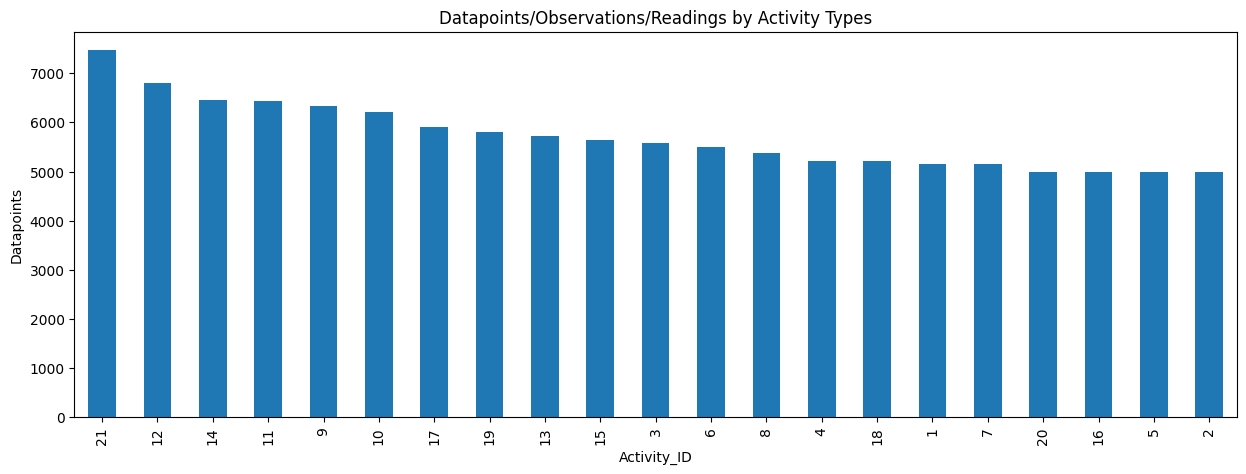

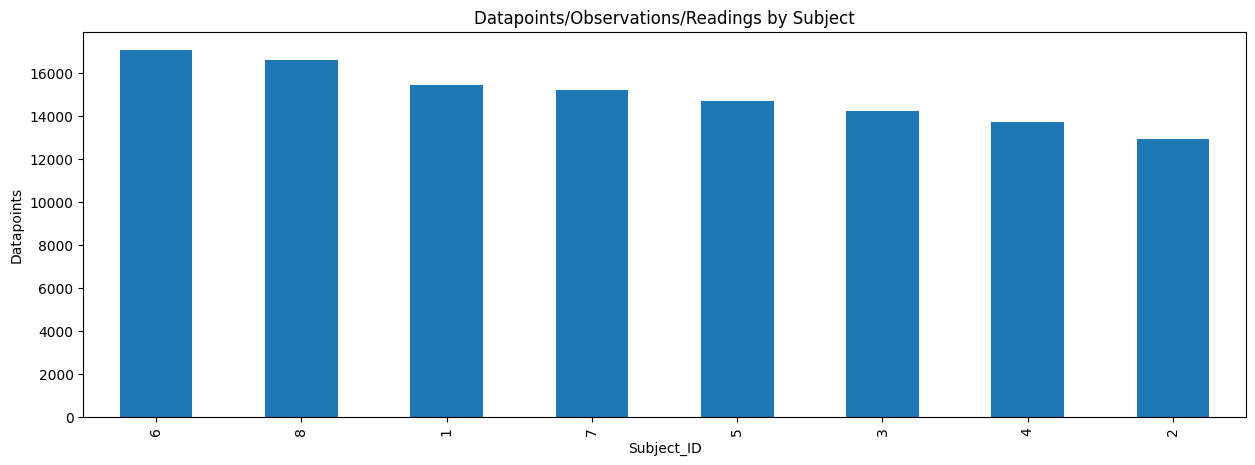

In [9]:
plt.figure(figsize=(15, 5))

plt.xlabel('Activity Type')
plt.ylabel('Datapoints')
wrist_sensor_data_df['Activity_ID'].value_counts().plot(kind='bar',
                                  title='Datapoints/Observations/Readings by Activity Types')
plt.show()

plt.figure(figsize=(15, 5))
plt.xlabel('Subject')
plt.ylabel('Datapoints')
wrist_sensor_data_df['Subject_ID'].value_counts().plot(kind='bar',
                                 title='Datapoints/Observations/Readings by Subject')
plt.show()

## Grouping Dataset: Groupby [ subject, trial ]. 8 Subject * 4 trial == 32 Groups


In [10]:
grouped_data = UTD1_dataset.groupby(['Subject_ID', 'Trial_ID'])

# Initialize an empty list to store group DataFrames
group_list = []

# Iterate through the groups and append each group to the list
for _, group_data in grouped_data:
    group_df = group_data.reset_index(drop=True)  # Reset index and drop old index column
    group_list.append(group_df)


In [11]:
group_list[0]

,ACC_X,ACC_Y,ACC_Z,GYRO_X,GYRO_Y,GYRO_Z,Activity_ID,Subject_ID,Trial_ID
0,-0.959473,-0.177734,-0.192871,5.221374,1.526718,0.152672,1,1,1
1,-0.961914,-0.153320,-0.159912,6.778626,1.954198,0.244275,1,1,1
2,-0.974609,-0.152832,-0.145996,11.267176,3.175573,1.099237,1,1,1
3,-0.941895,-0.135742,-0.127930,16.885496,4.732824,2.320611,1,1,1
4,-0.958252,-0.201416,-0.139404,16.030534,4.000000,0.366412,1,1,1
...,...,...,...,...,...,...,...,...,...
3942,-0.920654,-0.309082,-0.017334,-27.969466,-3.908397,-2.839695,21,1,1
3943,-0.918213,-0.312500,-0.016602,-25.618321,-5.770992,2.076336,21,1,1
3944,-0.921875,-0.333008,-0.016846,-22.320611,-7.267176,6.106870,21,1,1
3945,-0.919434,-0.340576,-0.019287,-19.480916,-8.335878,9.496183,21,1,1


## Windowing the Grouped Dataset

In [12]:
def create_windows(window_size, step, grouped_df, strategy="mode", sub_strategy="multi_label", type="padding"):
  windowed_data = []
  windowed_label = []
  if strategy == "bidirectional_windowing":
    end = len(grouped_df)
    step = 1
  else:
    end = len(grouped_df) - window_size
  for i in range(0, end, step):
    window_data = grouped_df.iloc[i: i+window_size, :]
    if strategy == "mode":
      window_label = mode(window_data["Activity_ID"])[0]
    elif strategy == "multi_label":
      unique_activities = window_data["Activity_ID"].unique()
      if len(unique_activities) == 1:
        window_label = unique_activities[0]
      elif len(unique_activities) == 2:
        window_label = "_".join(map(str, sorted(unique_activities)))
      else:
        print(unique_activities)
        raise Exception("Not combining more than 2 labels in transition windows. Stop")
    elif strategy == "bidirectional_windowing":
      if type == "padding":
        if i < window_size:
            left_start = 0
            left_padding = window_size - i
        else:
            left_start = i - window_size
            left_padding = 0

        window_data_left = grouped_df.iloc[left_start: i, :]
        # Add zero padding to the left if necessary
        if left_padding > 0:
            zero_padding_left = pd.DataFrame(0, index=range(left_padding), columns=grouped_df.columns)
            window_data_left = pd.concat([zero_padding_left, window_data_left], axis=0, ignore_index=True)
            window_data_left.reset_index(drop=True, inplace=True)
            # print(f"Size of window data left: {len(window_data_left)}")

        # Calculate the end index for the right window
        right_end = i + window_size
        if right_end > len(grouped_df):
            right_padding = right_end - len(grouped_df)
            window_data_right = grouped_df.iloc[i:, :]
            
            # Add zero padding to the right if necessary
            zero_padding_right = pd.DataFrame(0, index=range(right_padding), columns=grouped_df.columns)
            window_data_right = pd.concat([window_data_right, zero_padding_right], axis=0, ignore_index=True)
            window_data_right.reset_index(drop=True, inplace=True)
            # print(f"Size of window data right: {len(window_data_right)}")
        else:
            window_data_right = grouped_df.iloc[i:right_end, :]

      else:
        if i < window_size:
          left_start = 0
        else:
          left_start = i - window_size
        window_data_left = grouped_df.iloc[left_start: i, :]
        window_data_right = grouped_df.iloc[i: i+window_size, :]
      if len(window_data_left) != window_size:
        # print("Right Window Choosen")
        window_data = window_data_right.copy()
      elif len(window_data_right) != window_size:
        # print("Left Window Choosen")
        window_data = window_data_left.copy()
      elif len(window_data_left) == window_size and len(window_data_right) == window_size:
        # print("Bidirection Window Choosen")
        window_data = pd.concat([window_data_left, window_data_right], axis=0, ignore_index=True)
        window_data.reset_index(inplace=True, drop=True)
      else:
        raise Exception("Something went wrong")
      if sub_strategy == "multi_label":
        unique_activities = window_data["Activity_ID"].unique()
        if len(unique_activities) == 1:
          window_label = unique_activities[0]
        elif len(unique_activities) == 2:
          window_label = "_".join(map(str, sorted(unique_activities)))
        else:
          print(unique_activities)
          raise Exception("Not combining more than 2 labels in transition windows. Stop")
      elif sub_strategy == "single_label":
        window_label = grouped_df.loc[i, "Activity_ID"]
      elif sub_strategy == "double_datapoint":
        if not window_data_left.empty and not window_data_right.empty:
          # print("Both Windows Choosen")
          window_data = [window_data_left, window_data_right]
          window_label = [grouped_df.loc[i, "Activity_ID"]] * 2
        elif window_data_left.empty:
          # print("Right Windows Choosen")
          window_data = window_data_right.copy()
          window_label = grouped_df.loc[i, "Activity_ID"]
        elif window_data_right.empty:
          # print("Left Windows Choosen")
          window_data = window_data_left.copy()
          window_label = grouped_df.loc[i, "Activity_ID"]
      else:
        raise NotImplementedError("Any other SubStrategy technique is not implemented")
    elif strategy == "discard_transition_windows":
        unique_activities = window_data["Activity_ID"].unique()
        if len(unique_activities) > 1:
          continue
        else:
          window_label = unique_activities[0]
    else:
        raise NotImplementedError("Invaild Strategy type")
    # if window_label == "7_9":
    #   continue
    if isinstance(window_data, list):
      windowed_data.extend(window_data)
      windowed_label.extend(window_label)
    else:
      windowed_data.append(window_data)
      windowed_label.append(window_label)
  return windowed_data, windowed_label

In [13]:
for _, group in grouped_data:
  dataset, label = create_windows(50, 50, group.reset_index(drop=True), strategy="multi_label")

In [14]:
len(dataset)

80

In [15]:
dataset[0]

,ACC_X,ACC_Y,ACC_Z,GYRO_X,GYRO_Y,GYRO_Z,Activity_ID,Subject_ID,Trial_ID
0,-1.005615,-0.176758,0.176025,3.603053,-0.946565,0.519084,1,8,4
1,-1.000977,-0.170166,0.156006,5.862595,-1.343511,-0.183206,1,8,4
2,-0.981689,-0.180664,0.125977,9.007634,-1.526718,-0.030534,1,8,4
3,-0.982666,-0.204590,0.116943,8.946565,-1.160305,0.061069,1,8,4
4,-1.004150,-0.231934,0.126709,5.801527,-0.305344,-0.396947,1,8,4
5,-1.007324,-0.238037,0.144287,0.274809,0.854962,-0.793893,1,8,4
6,-0.999756,-0.222900,0.147461,-5.496183,2.167939,-0.793893,1,8,4
7,-1.018799,-0.177979,0.108887,-9.190840,2.961832,-0.946565,1,8,4
8,-1.009521,-0.138916,0.054688,-10.778626,4.458015,0.519084,1,8,4
9,-1.000488,-0.170898,-0.033936,-11.938931,6.198473,4.671756,1,8,4


In [16]:
type(dataset[0])

pandas.core.frame.DataFrame

In [17]:
label[0: 5]

[1, 1, 1, '1_2', 2]

## Plots for Rolling Bidirection Windows; No Discarding Windows

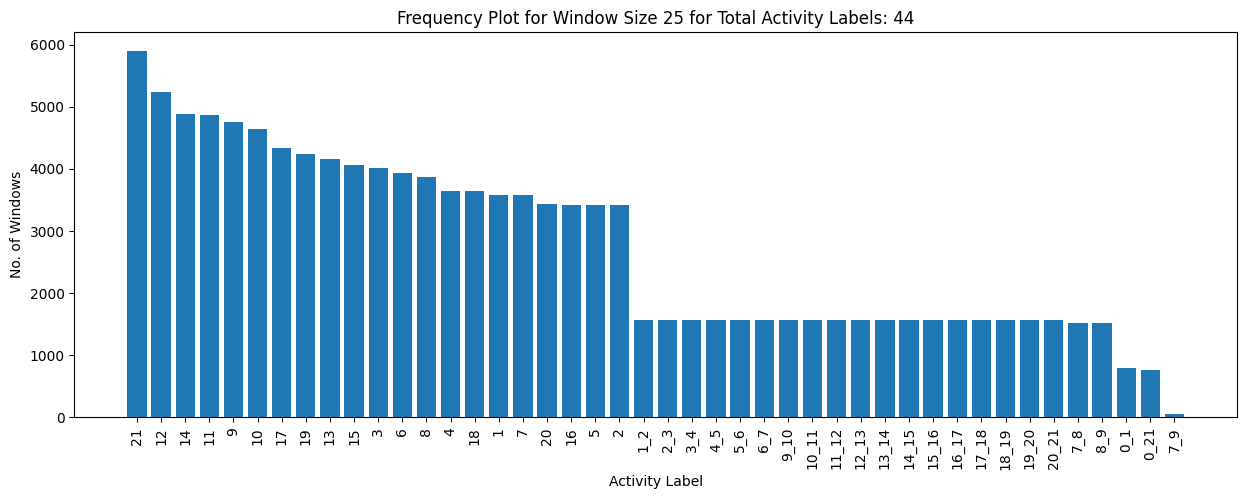

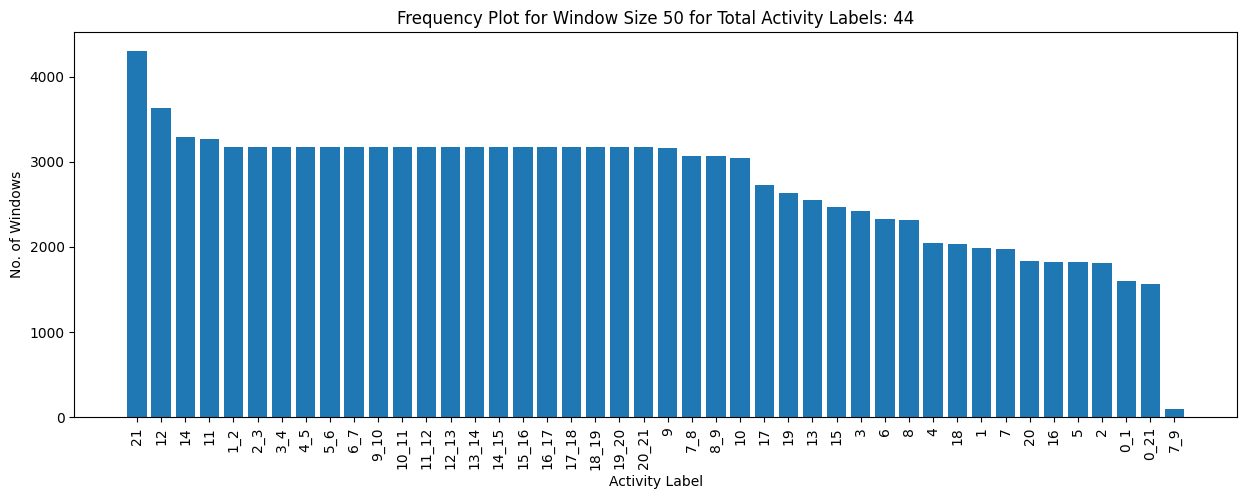

In [18]:
for window_size in range(25, 75, 25):
  labels = []
  for _, group in grouped_data:
    # print(f"Group size: {len(group.reset_index())}")
    _, group_labels = create_windows(window_size, 1, group.reset_index(drop=True), strategy="bidirectional_windowing")
    # print(f"Total lables for a group: {len(group_labels)}")
    labels.extend(group_labels)

  counter = Counter(labels)
  plt.figure(figsize=(15, 5))

  values = list(counter.keys())
  frequencies = list(counter.values())
  sorted_data = sorted(zip(list(map(str, values)), frequencies), key = lambda x: x[1], reverse=True)
  sorted_values, sorted_frequencies = zip(*sorted_data)
  plt.bar(sorted_values, sorted_frequencies)
  plt.xlabel('Activity Label')
  plt.ylabel('No. of Windows')
  plt.title(f"Frequency Plot for Window Size {window_size} for Total Activity Labels: {len(sorted_values)}")
  plt.xticks(rotation=90)
  plt.show()

## Plots for Full Non Overlapping Windows; Discarding Transition Windows

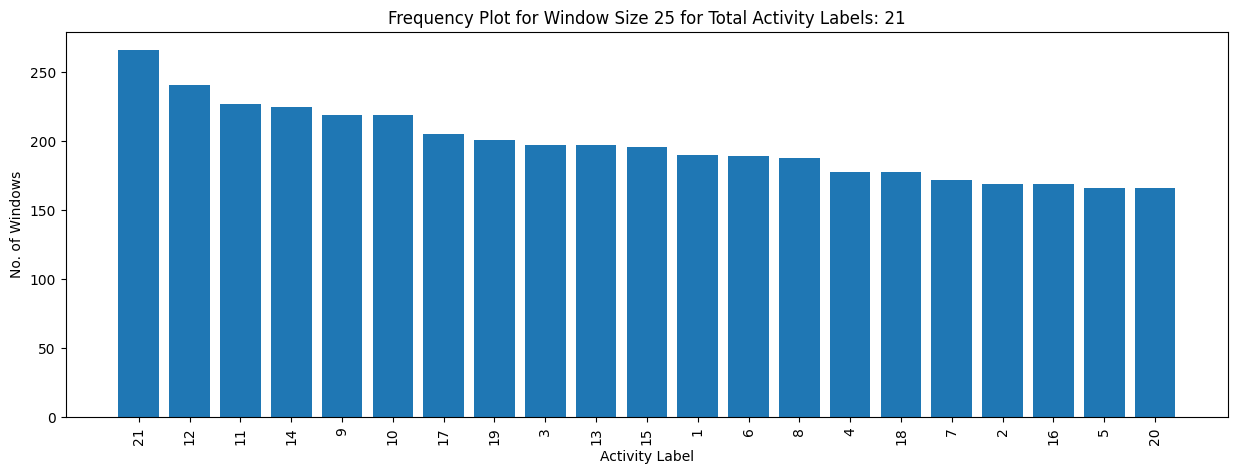

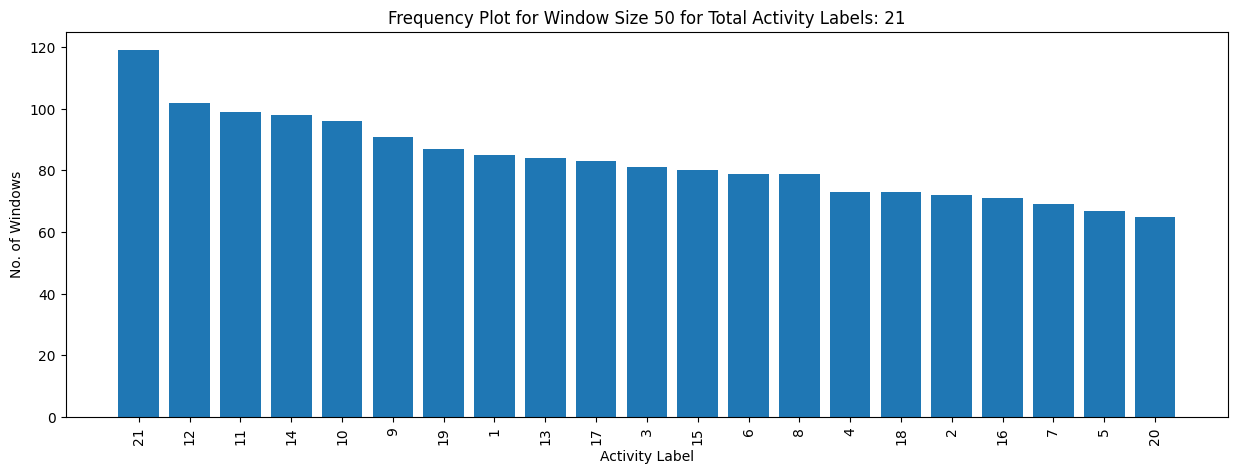

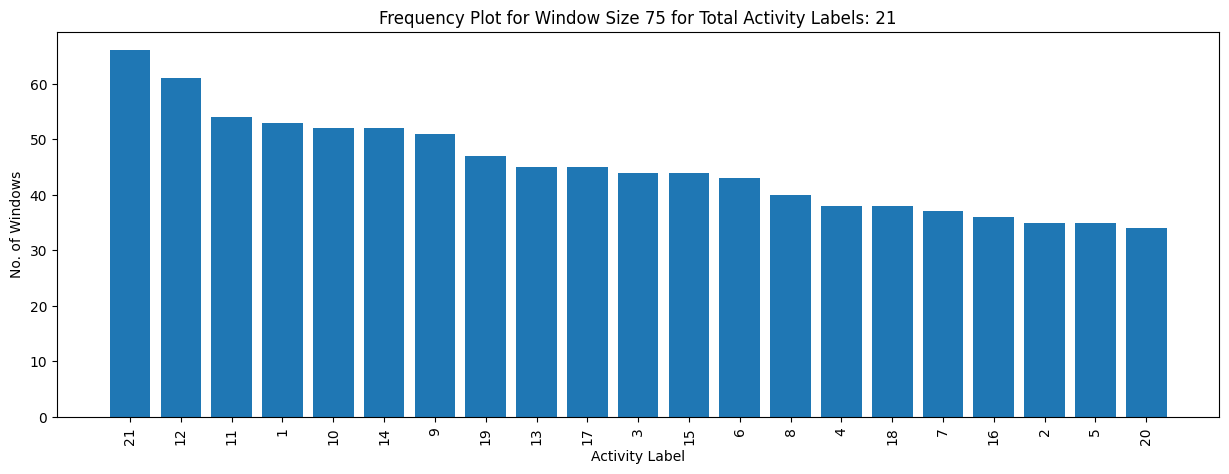

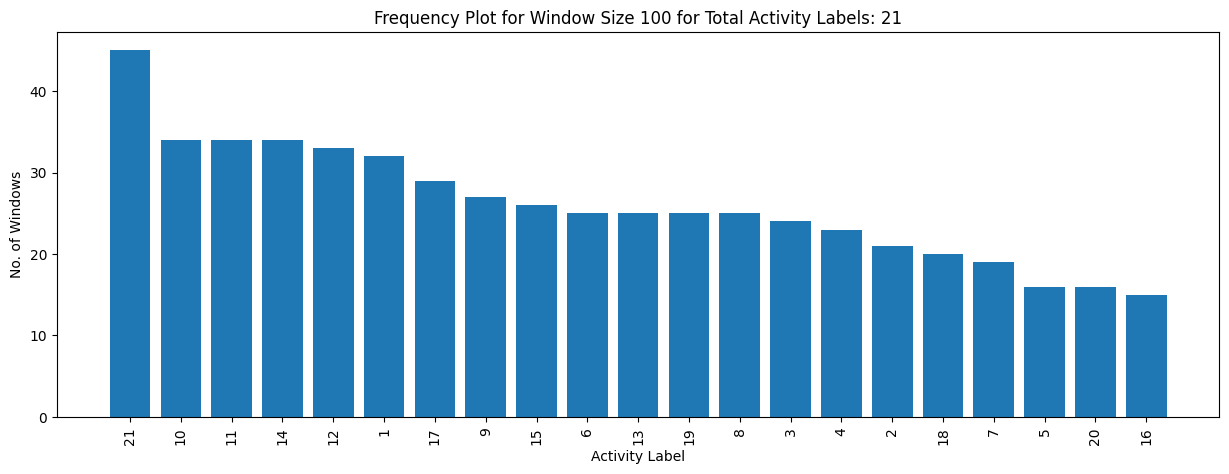

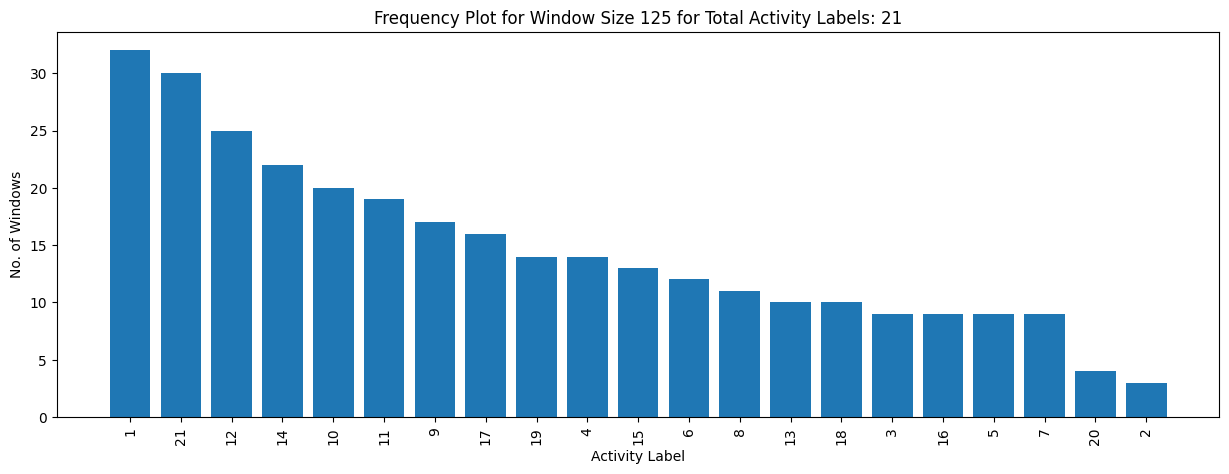

In [19]:
for window_size in range(25, 150, 25):
  labels = []
  for _, group in grouped_data:
    # print(f"Group size: {len(group.reset_index())}")
    _, group_labels = create_windows(window_size, window_size, group.reset_index(drop=True), strategy="discard_transition_windows")
    # print(f"Total lables for a group: {len(group_labels)}")
    labels.extend(group_labels)

  counter = Counter(labels)
  plt.figure(figsize=(15, 5))

  values = list(counter.keys())
  frequencies = list(counter.values())
  sorted_data = sorted(zip(list(map(str, values)), frequencies), key = lambda x: x[1], reverse=True)
  sorted_values, sorted_frequencies = zip(*sorted_data)
  plt.bar(sorted_values, sorted_frequencies)
  plt.xlabel('Activity Label')
  plt.ylabel('No. of Windows')
  plt.title(f"Frequency Plot for Window Size {window_size} for Total Activity Labels: {len(sorted_values)}")
  plt.xticks(rotation=90)
  plt.show()

## Plots for Full Non Overlapping Windows with Mode Labels; Discarding the remainder window

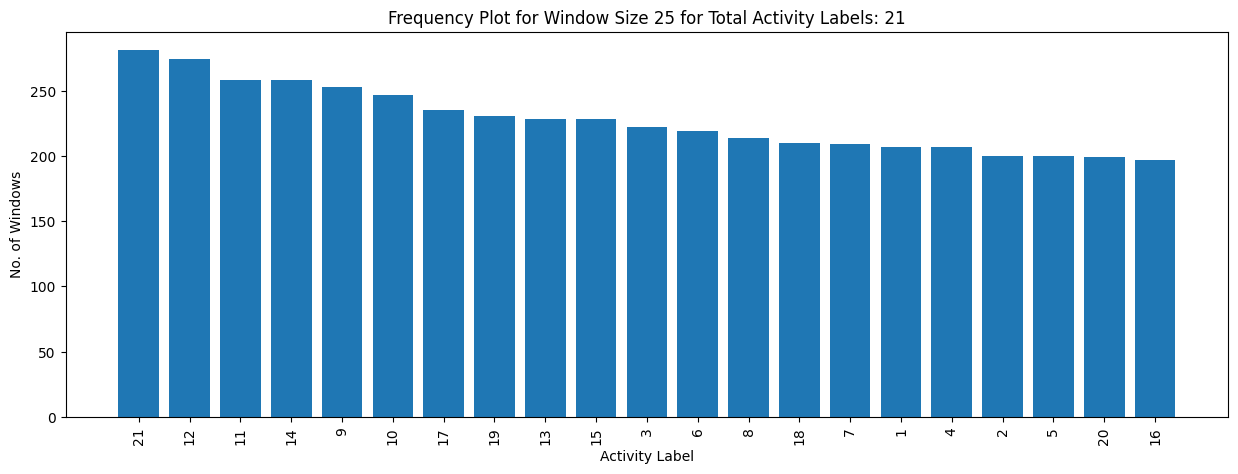

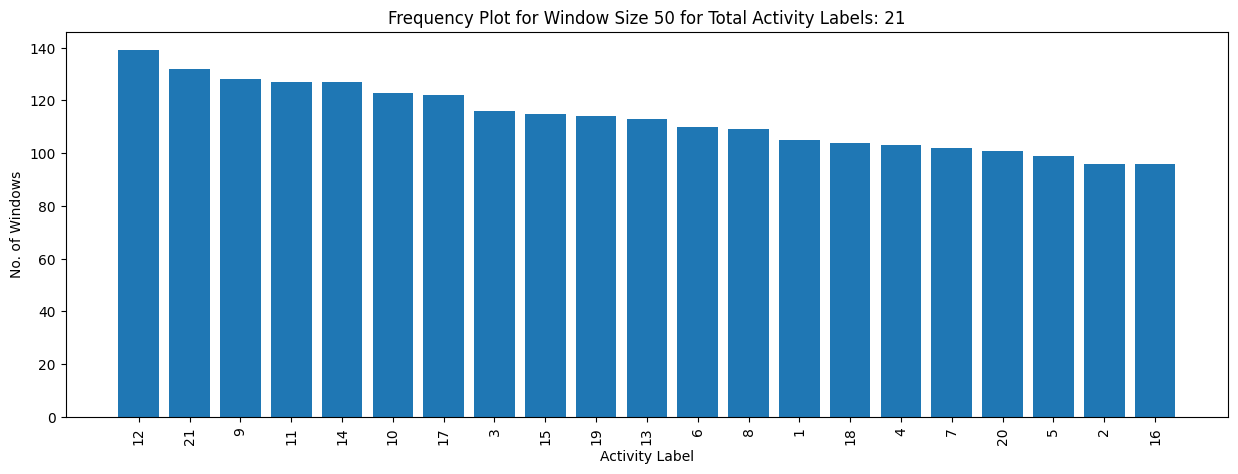

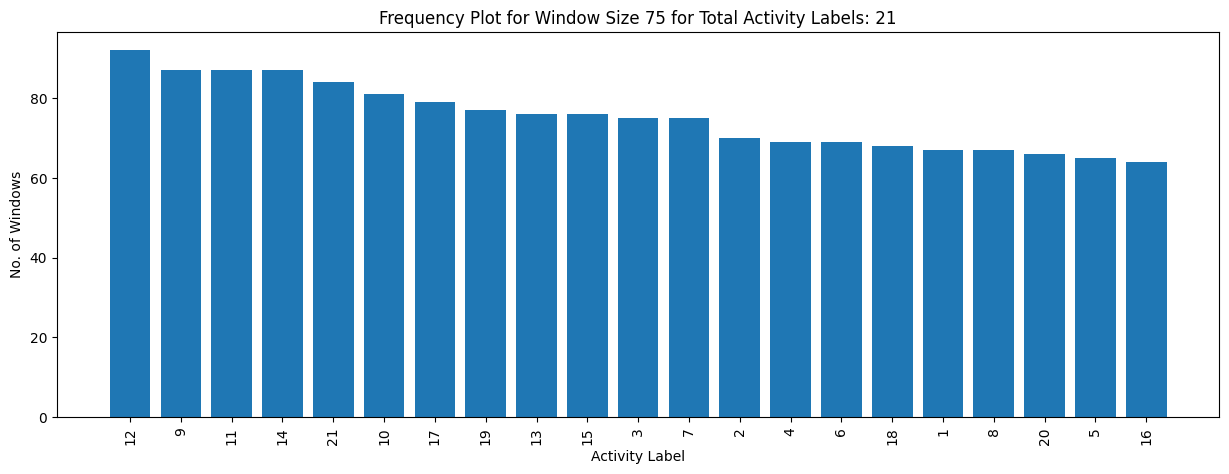

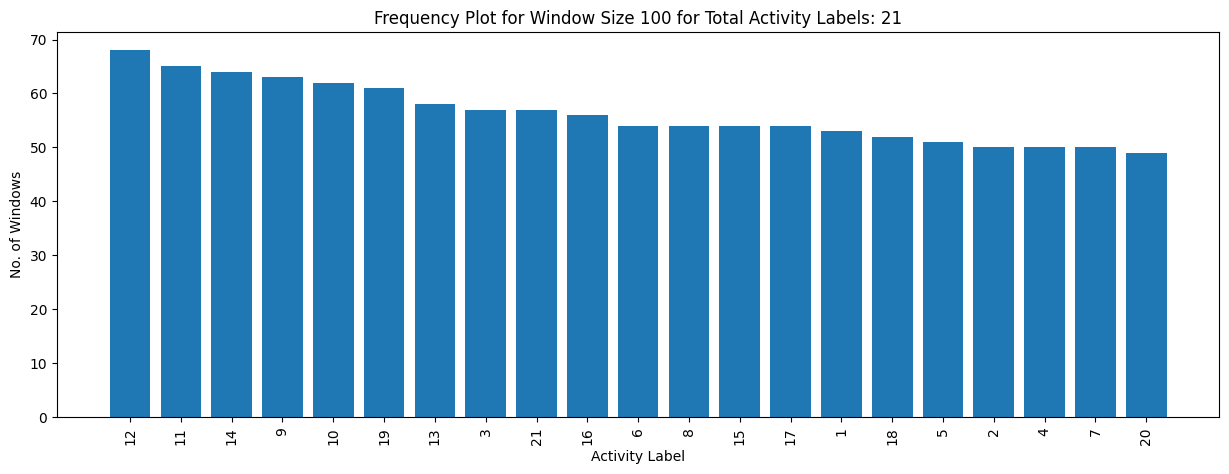

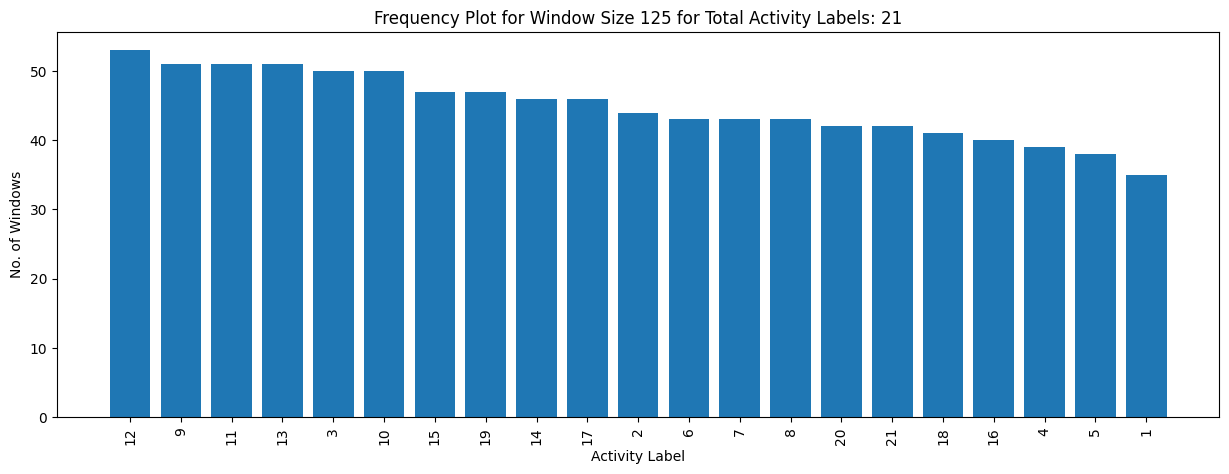

In [20]:
for window_size in range(25, 150, 25):
  labels = []
  for _, group in grouped_data:
    # print(f"Group size: {len(group.reset_index())}")
    _, group_labels = create_windows(window_size, window_size, group.reset_index(drop=True), strategy="mode")
    # print(f"Total lables for a group: {len(group_labels)}")
    labels.extend(group_labels)

  counter = Counter(labels)
  plt.figure(figsize=(15, 5))

  values = list(counter.keys())
  frequencies = list(counter.values())
  sorted_data = sorted(zip(list(map(str, values)), frequencies), key = lambda x: x[1], reverse=True)
  sorted_values, sorted_frequencies = zip(*sorted_data)
  plt.bar(sorted_values, sorted_frequencies)
  plt.xlabel('Activity Label')
  plt.ylabel('No. of Windows')
  plt.title(f"Frequency Plot for Window Size {window_size} for Total Activity Labels: {len(sorted_values)}")
  plt.xticks(rotation=90)
  plt.show()

## Plots for Full Non-Overlapping Windows Using Multi Labels; Discarding the remainder window

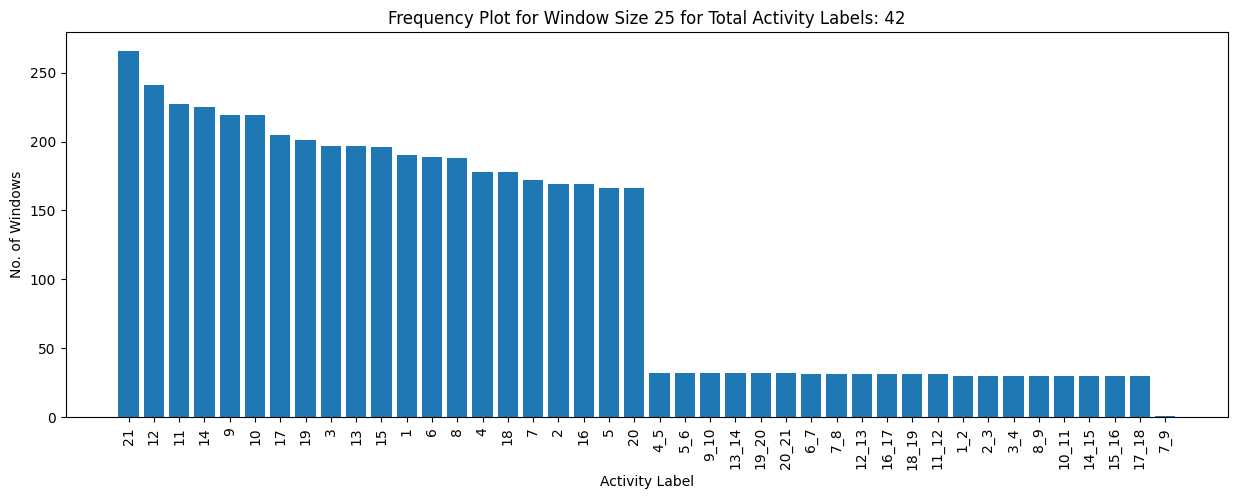

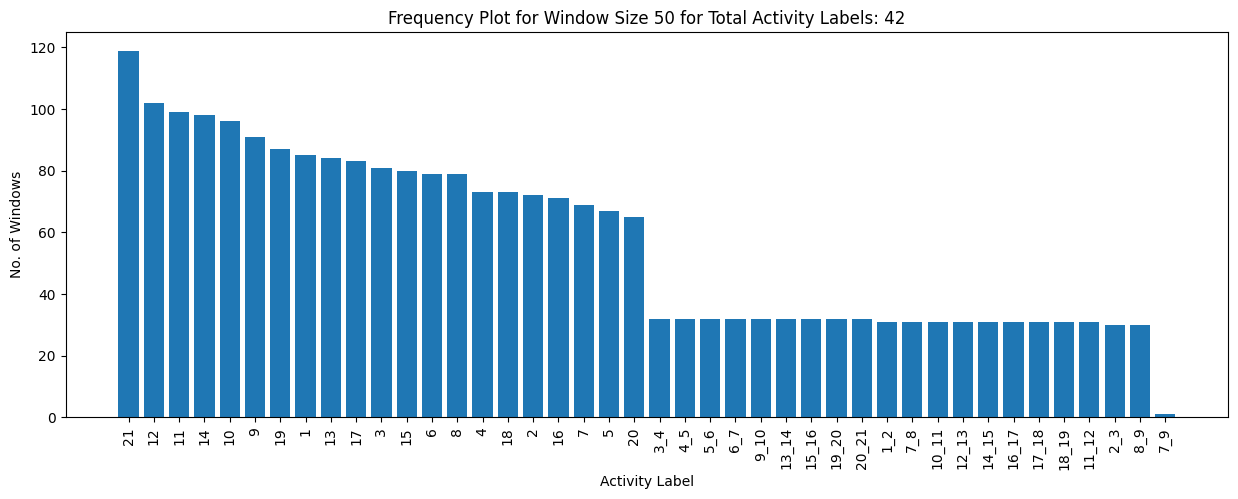

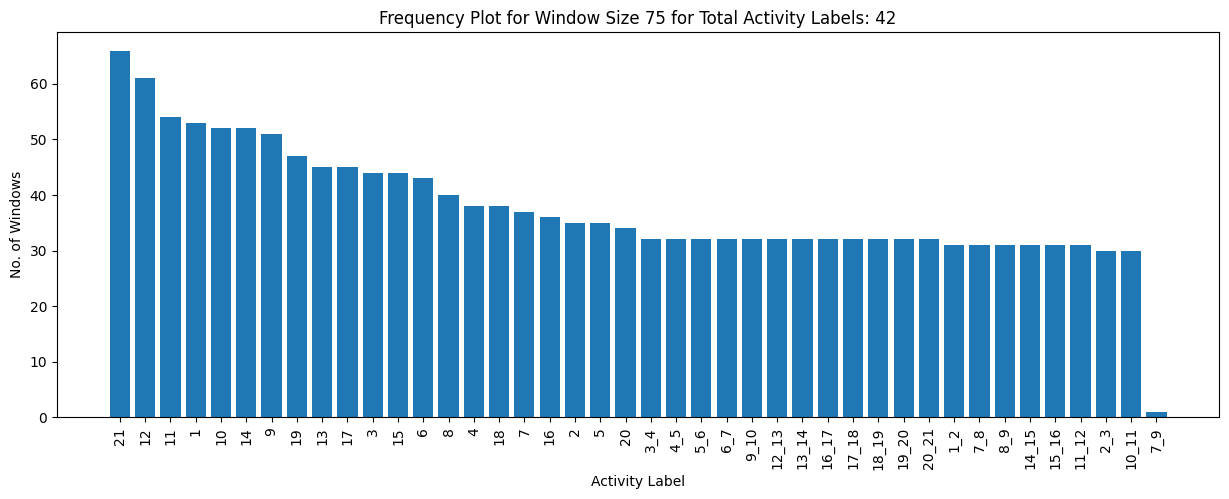

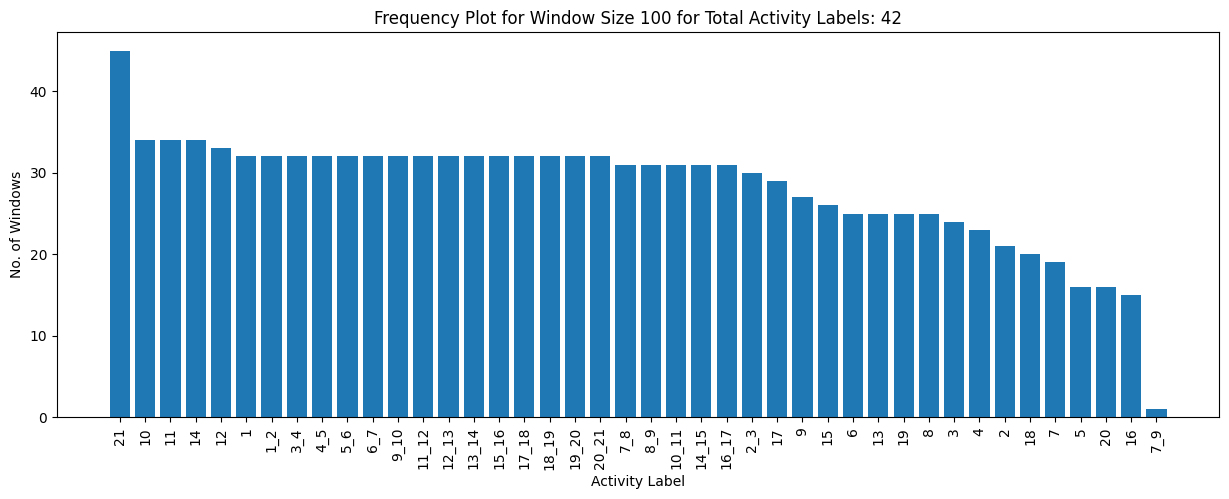

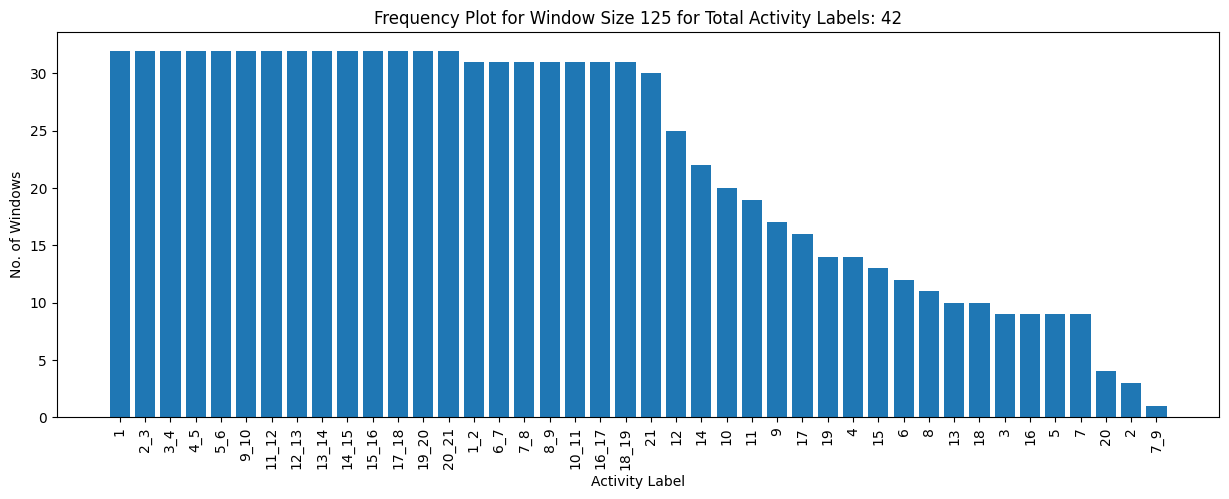

In [21]:
for window_size in range(25, 150, 25):
  labels = []
  for _, group in grouped_data:
    # print(f"Group size: {len(group.reset_index())}")
    _, group_labels = create_windows(window_size, window_size, group.reset_index(drop=True), strategy="multi_label")
    # print(f"Total lables for a group: {len(group_labels)}")
    labels.extend(group_labels)

  counter = Counter(labels)
  plt.figure(figsize=(15, 5))

  values = list(counter.keys())
  frequencies = list(counter.values())
  sorted_data = sorted(zip(list(map(str, values)), frequencies), key = lambda x: x[1], reverse=True)
  sorted_values, sorted_frequencies = zip(*sorted_data)
  plt.bar(sorted_values, sorted_frequencies)
  plt.xlabel('Activity Label')
  plt.ylabel('No. of Windows')
  plt.title(f"Frequency Plot for Window Size {window_size} for Total Activity Labels: {len(sorted_values)}")
  plt.xticks(rotation=90)
  plt.show()

## Plots for Semi Non-Overlapping Windows (50% overlap) with Multi Labels; Discarding the remainder window

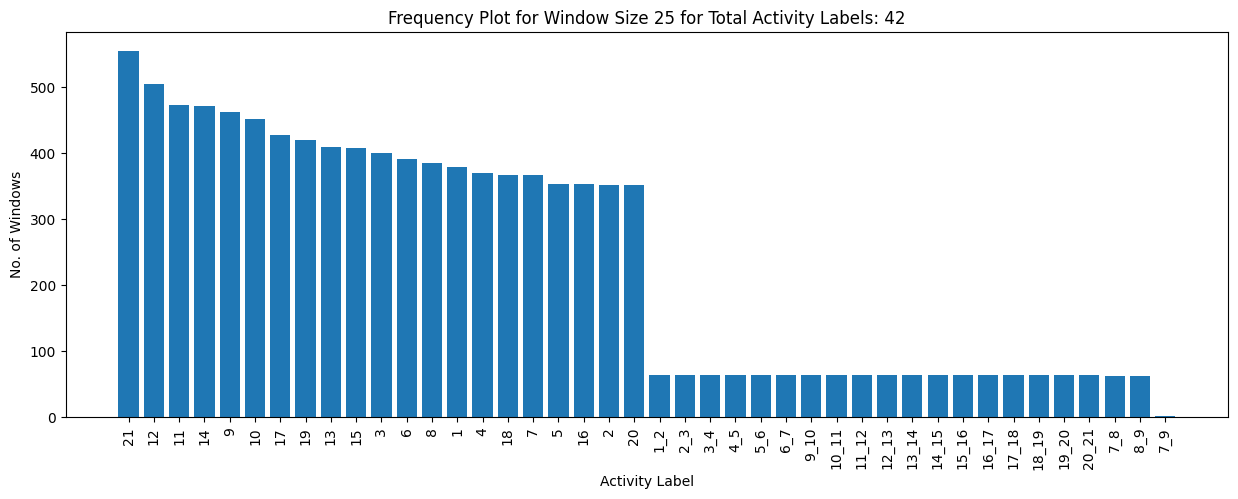

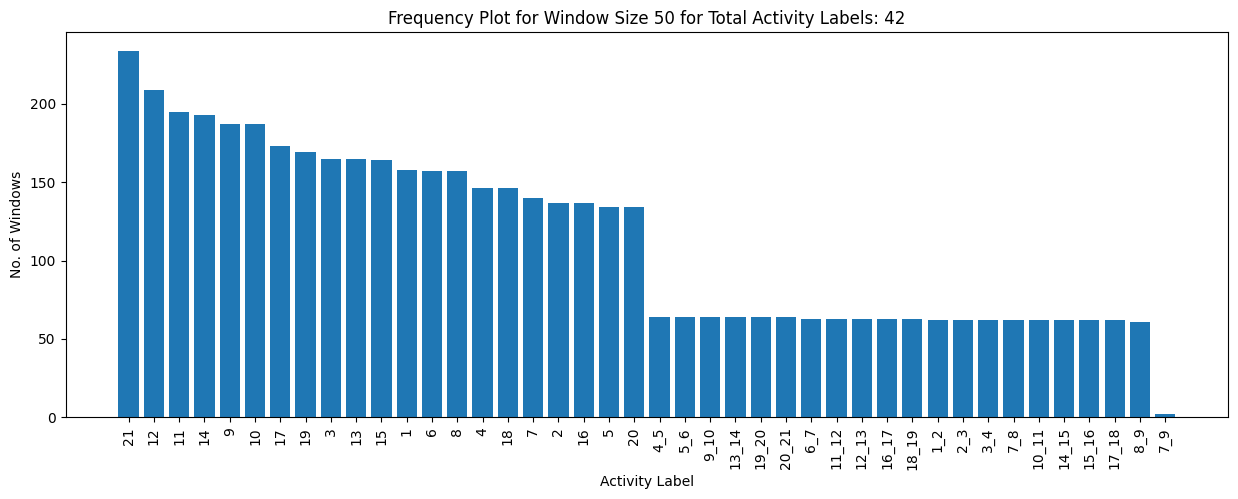

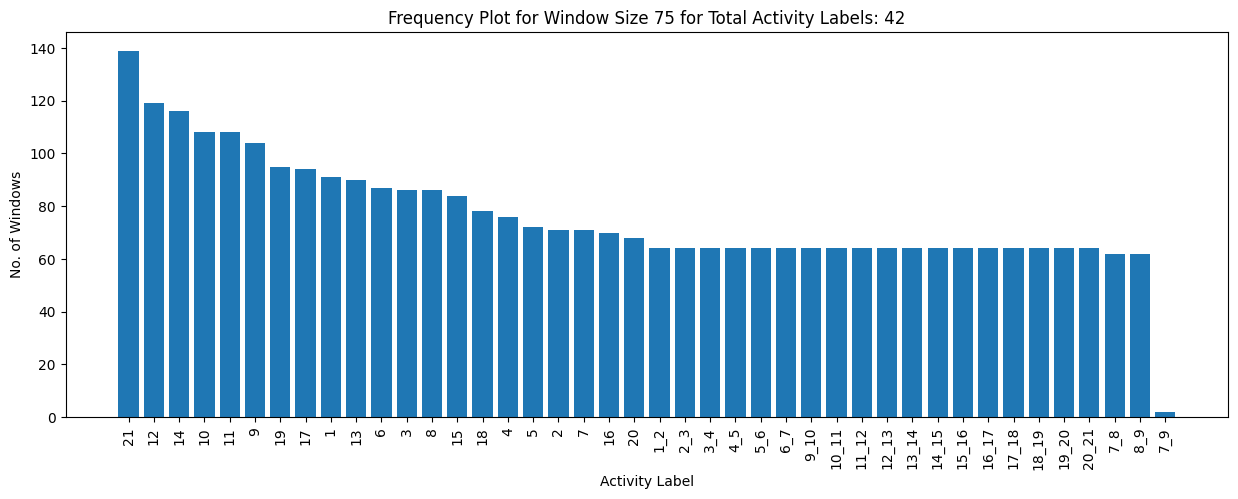

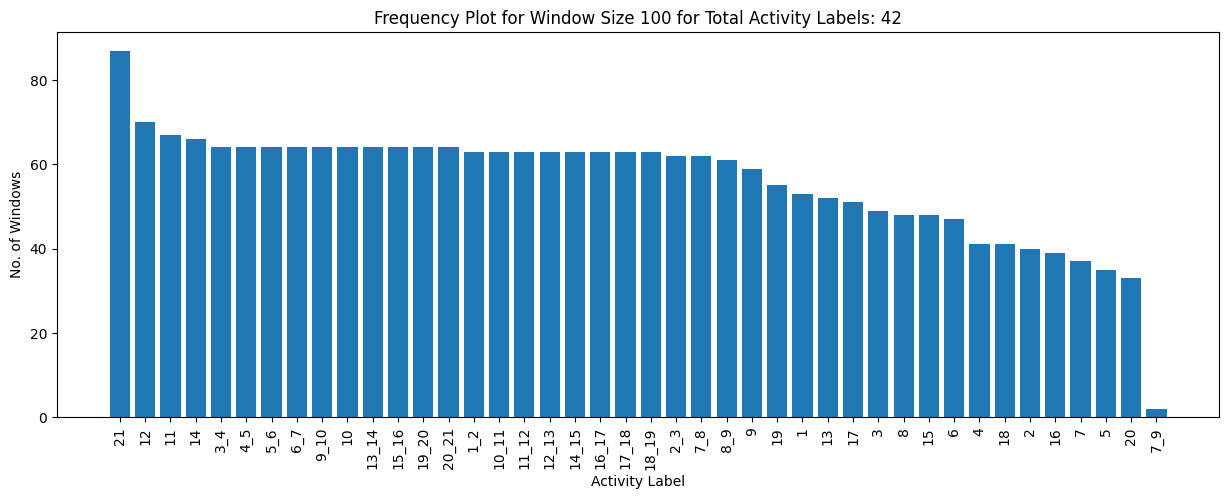

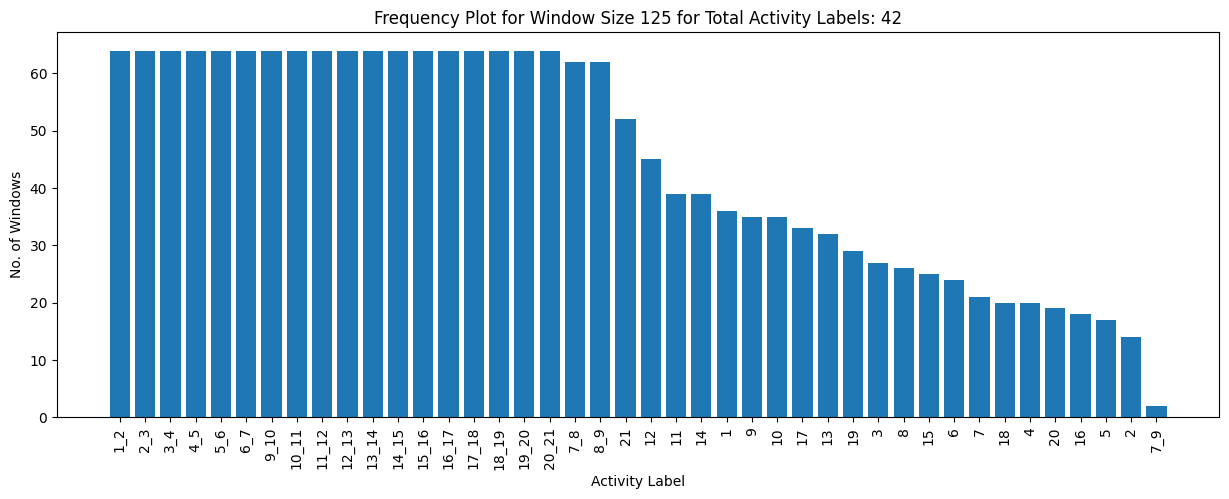

In [22]:
for window_size in range(25, 150, 25):
  labels = []
  for _, group in grouped_data:
    # print(f"Group size: {len(group.reset_index())}")
    _, group_labels = create_windows(window_size, int(window_size/2), group.reset_index(drop=True), strategy="multi_label")
    # print(f"Total lables for a group: {len(group_labels)}")
    labels.extend(group_labels)

  counter = Counter(labels)
  plt.figure(figsize=(15, 5))

  values = list(counter.keys())
  frequencies = list(counter.values())
  sorted_data = sorted(zip(list(map(str, values)), frequencies), key = lambda x: x[1], reverse=True)
  sorted_values, sorted_frequencies = zip(*sorted_data)
  plt.bar(sorted_values, sorted_frequencies)
  plt.xlabel('Activity Label')
  plt.ylabel('No. of Windows')
  plt.title(f"Frequency Plot for Window Size {window_size} for Total Activity Labels: {len(sorted_values)}")
  plt.xticks(rotation=90)
  plt.show()

## Plots for Semi Non-Overlapping Windows (50% overlap) with Mode Labels; Discarding the remainder window

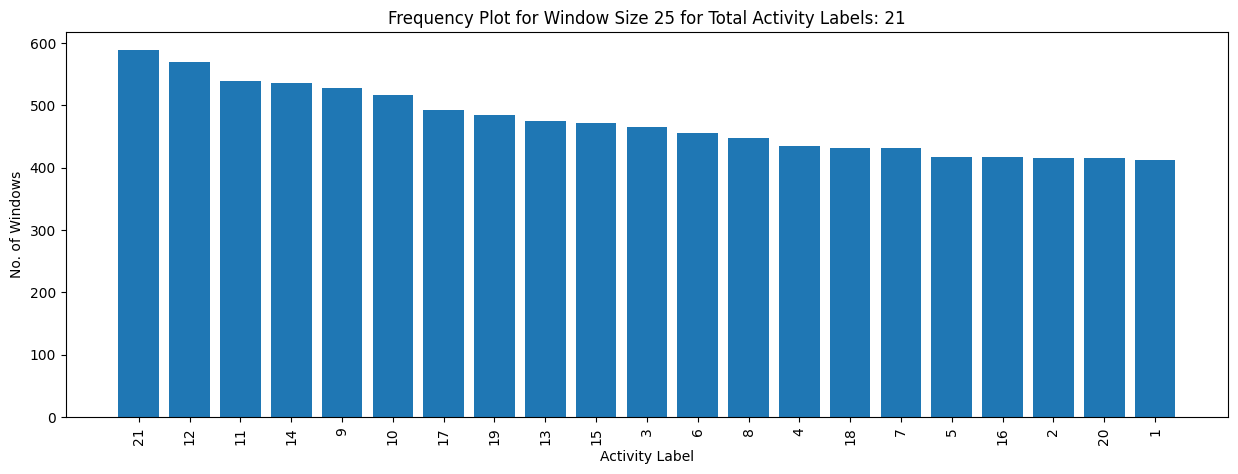

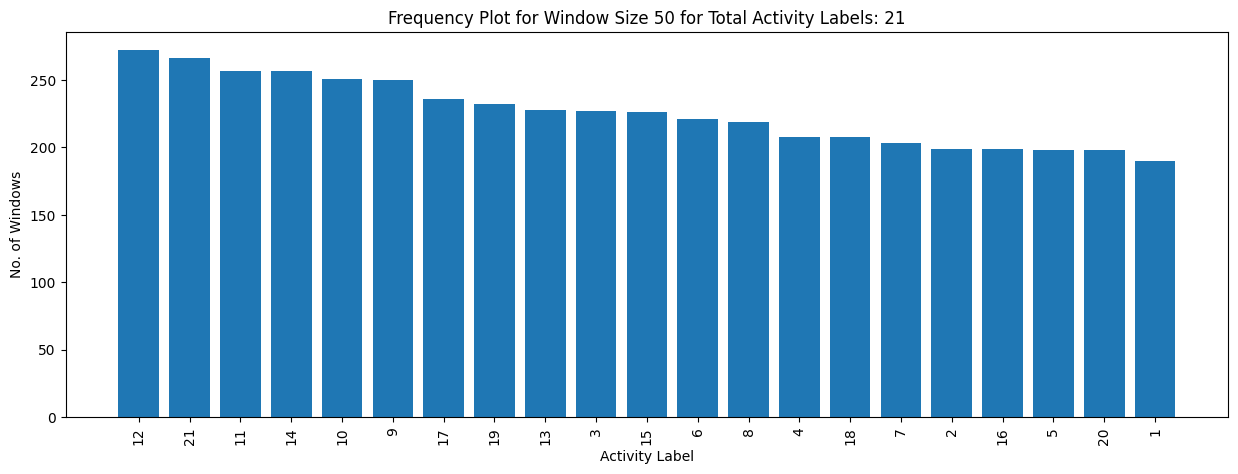

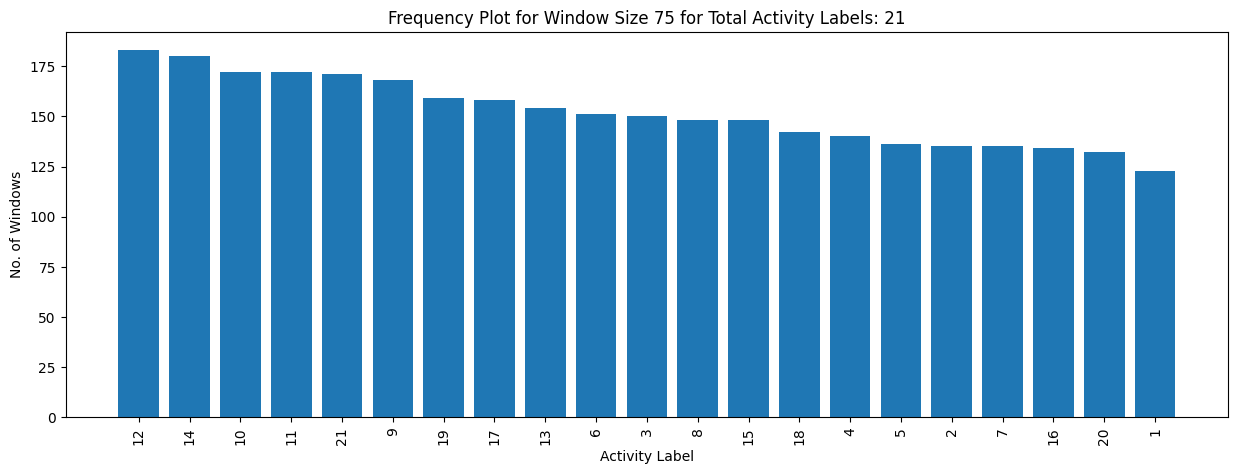

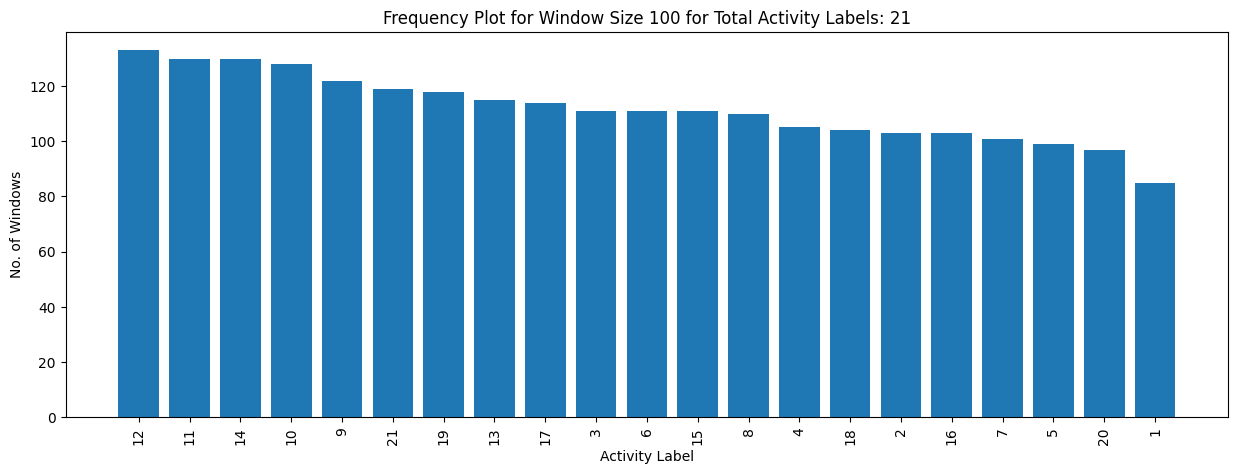

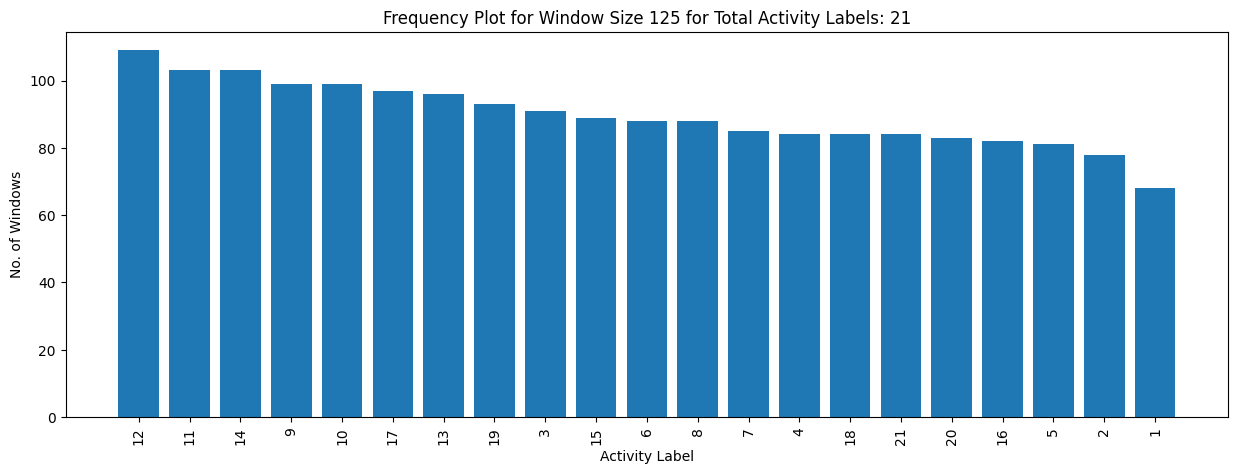

In [23]:
for window_size in range(25, 135, 25):
  labels = []
  for _, group in grouped_data:
    # print(f"Group size: {len(group.reset_index())}")
    _, group_labels = create_windows(window_size, int(window_size/2), group.reset_index(drop=True), strategy="mode")
    # print(f"Total lables for a group: {len(group_labels)}")
    labels.extend(group_labels)

  counter = Counter(labels)
  plt.figure(figsize=(15, 5))

  values = list(counter.keys())
  frequencies = list(counter.values())
  sorted_data = sorted(zip(list(map(str, values)), frequencies), key = lambda x: x[1], reverse=True)
  sorted_values, sorted_frequencies = zip(*sorted_data)
  plt.bar(sorted_values, sorted_frequencies)
  plt.xlabel('Activity Label')
  plt.ylabel('No. of Windows')
  plt.title(f"Frequency Plot for Window Size {window_size} for Total Activity Labels: {len(sorted_values)}")
  plt.xticks(rotation=90)
  plt.show()

## Handcrafting Features from Windows (Feature Extraction)

In [24]:
# Function to calculate features
def calculate_window_features(data):
    features = {
        'Average': np.mean(data),
        'SD': np.std(data),
        'AAD': np.mean(np.abs(np.diff(data, n=1))),
        'Maximum': np.max(data),
        'Minimum': np.min(data),
        'Median': np.median(data),
        'Skew': skew(data),
        'Kurtosis': kurtosis(data),
        'IQR': iqr(data),
        'AreaUnderCurve': simps(data),
        'SquareAreaUnderCurve': simps(data**2) # doubt
    }
    return features

In [25]:
signal_features = ['ACC_X', 'ACC_Y', 'ACC_Z', 'GYRO_X', 'GYRO_Y', 'GYRO_Z']

In [26]:
def get_window_features(dataset_df, window_size, strategy="multi_label", type="full_non_overlapping", sub_strategy="multi_label", sub_type="padding"):
  windowed_features_data = []
  grouped_data = dataset_df.groupby(['Subject_ID', 'Trial_ID'])
  all_windowed_dataset  = []
  all_labels = []
  dp_list = []
  for group_no, group_data in grouped_data:
      group_df = group_data.reset_index(drop=True)
      if type == "full_non_overlapping":
        windowed_dataset, windowed_labels = create_windows(window_size, window_size, group_df, strategy=strategy, sub_strategy=sub_strategy, type=sub_type)
      elif type == "semi_non_overlapping":
        windowed_dataset, windowed_labels = create_windows(window_size, window_size//2, group_df, strategy=strategy, sub_strategy=sub_strategy, type=sub_type)
      elif type == "rolling_window":
         windowed_dataset, windowed_labels = create_windows(window_size, 1, group_df, strategy=strategy, sub_strategy=sub_strategy, type=sub_type)
        #  print(f"Windowed dataset length: {len(windowed_dataset)}")
      else:
        raise NotImplementedError("Not supported Dataset prepration startegy")
      # print(f"Group length: {len(group_df)}")

      all_windowed_dataset.extend(windowed_dataset)
      all_labels.extend(windowed_labels)
      
      if strategy == "bidirectional_windowing":
        for index in range(len(group_df)):
          if sub_type == "padding" and sub_strategy == "double_datapoint":
            dp_list.append(group_df.iloc[[index]].copy())
            dp_list.append(group_df.iloc[[index]].copy())
          else:
            if index != 0:
              if sub_strategy == "double_datapoint":
                dp_list.append(group_df.iloc[[index]].copy())
                dp_list.append(group_df.iloc[[index]].copy())
              else:
                dp_list.append(group_df.iloc[[index]].copy())
            else:
              dp_list.append(group_df.iloc[[index]].copy())
            
        # print(f"dp_list length: {len(dp_list)}")

  # Iterate through windows and calculate window features for each singal feature   
  for window_number, window in enumerate(all_windowed_dataset):
      window_all_features_dict = {}
      if strategy == "bidirectional_windowing":
         dp_list[window_number]["Window_Number"] = window_number
      else:
        all_windowed_dataset[window_number]["Window_Number"] = window_number

      for signal_feature in signal_features:
          signal_data = window[signal_feature].values
          window_features_dict = calculate_window_features(signal_data)

          for feature_name, feature_value in window_features_dict.items():
              window_all_features_dict[f'{signal_feature}_{feature_name}'] = feature_value

      for sensor_data in ["ACC", "GYRO"]:
        component_data = window[[f"{sensor_data}_X", f"{sensor_data}_Y", f"{sensor_data}_Z"]].values
        # print(component_data.shape)
        # print(np.mean(np.sqrt(np.sum(np.square(component_data), axis=1))))
        window_all_features_dict[f"{sensor_data}_ARA"] = np.mean(np.sqrt(np.sum(np.square(component_data), axis=1)), axis=0),

      # Add window_number corresponding to window_number
      window_all_features_dict['Window_Number'] = window_number
      window_all_features_dict["Label"] = all_labels[window_number]
      window_all_features_dict["Subject_ID"] = window["Subject_ID"].values[0]
      window_all_features_dict["Trial_ID"] = window["Trial_ID"].values[0]

      windowed_features_data.append(window_all_features_dict)
  if strategy == "bidirectional_windowing":
    return windowed_features_data, all_labels, dp_list
  else:
    return windowed_features_data, all_labels, all_windowed_dataset

In [27]:
UTD1_dataset.head()

,ACC_X,ACC_Y,ACC_Z,GYRO_X,GYRO_Y,GYRO_Z,Activity_ID,Subject_ID,Trial_ID
0,-0.959473,-0.177734,-0.192871,5.221374,1.526718,0.152672,1,1,1
1,-0.961914,-0.153320,-0.159912,6.778626,1.954198,0.244275,1,1,1
2,-0.974609,-0.152832,-0.145996,11.267176,3.175573,1.099237,1,1,1
3,-0.941895,-0.135742,-0.127930,16.885496,4.732824,2.320611,1,1,1
4,-0.958252,-0.201416,-0.139404,16.030534,4.000000,0.366412,1,1,1


In [301]:
windowed_features_data, all_labels, all_windowed_dataset = get_window_features(UTD1_dataset, 100, strategy="bidirectional_windowing", type="rolling_window", sub_strategy="double_datapoint", sub_type="padding")

In [302]:
windowed_features_data_df = pd.DataFrame(windowed_features_data)

In [303]:
windowed_features_data_df["Label"].value_counts()

Label
21    14946
12    13602
14    12906
11    12864
9     12654
10    12416
17    11794
19    11602
13    11438
15    11264
3     11174
6     10992
8     10774
4     10430
18    10412
1     10300
7     10294
20     9998
16     9986
5      9980
2      9968
Name: count, dtype: int64

In [304]:
windowed_features_data_df["Window_Number"].unique()

array([     0,      1,      2, ..., 239791, 239792, 239793])

In [305]:
UTD1_dataset_with_window_number = pd.concat(all_windowed_dataset)

In [306]:
UTD1_dataset.shape

(119897, 9)

In [307]:
UTD1_dataset_with_window_number.shape

(239794, 10)

In [308]:
UTD1_dataset_with_window_number.head()

,ACC_X,ACC_Y,ACC_Z,GYRO_X,GYRO_Y,GYRO_Z,Activity_ID,Subject_ID,Trial_ID,Window_Number
0,-0.959473,-0.177734,-0.192871,5.221374,1.526718,0.152672,1,1,1,0
0,-0.959473,-0.177734,-0.192871,5.221374,1.526718,0.152672,1,1,1,1
1,-0.961914,-0.153320,-0.159912,6.778626,1.954198,0.244275,1,1,1,2
1,-0.961914,-0.153320,-0.159912,6.778626,1.954198,0.244275,1,1,1,3
2,-0.974609,-0.152832,-0.145996,11.267176,3.175573,1.099237,1,1,1,4


In [309]:
len(all_labels)

239794

In [310]:
len(all_windowed_dataset)

239794

In [311]:
UTD1_dataset_with_window_number.isnull().sum()

ACC_X            0
ACC_Y            0
ACC_Z            0
GYRO_X           0
GYRO_Y           0
GYRO_Z           0
Activity_ID      0
Subject_ID       0
Trial_ID         0
Window_Number    0
dtype: int64

In [312]:
windowed_features_data_df.isnull().sum()[windowed_features_data_df.isnull().sum() > 1]

ACC_X_Skew         32
ACC_X_Kurtosis     32
ACC_Y_Skew         32
ACC_Y_Kurtosis     32
ACC_Z_Skew         32
ACC_Z_Kurtosis     32
GYRO_X_Skew        32
GYRO_X_Kurtosis    32
GYRO_Y_Skew        32
GYRO_Y_Kurtosis    32
GYRO_Z_Skew        32
GYRO_Z_Kurtosis    32
dtype: int64

In [313]:
windowed_features_data_df.fillna(0, inplace=True)

In [314]:
UTD1_dataset_with_window_number["Window_Number"].unique()

array([     0,      1,      2, ..., 239791, 239792, 239793])

In [315]:
label_size = windowed_features_data_df.groupby("Label").size() > 1

In [316]:
label_size = label_size.reset_index()

In [317]:
label_size.columns = ["Label", "Window_Count"]

In [318]:
label_size

,Label,Window_Count
0,1,True
1,2,True
2,3,True
3,4,True
4,5,True
5,6,True
6,7,True
7,8,True
8,9,True
9,10,True


In [319]:
req_labels = label_size["Label"].unique()

In [320]:
len(req_labels)

21

In [321]:
windowed_features_data_df.shape

(239794, 72)

In [322]:
windowed_features_data_df = windowed_features_data_df[windowed_features_data_df["Label"].apply(lambda x: True if x in req_labels else False)]

In [323]:
windowed_features_data_df.head()

,ACC_X_Average,ACC_X_SD,ACC_X_AAD,ACC_X_Maximum,ACC_X_Minimum,ACC_X_Median,ACC_X_Skew,ACC_X_Kurtosis,ACC_X_IQR,ACC_X_AreaUnderCurve,...,GYRO_Z_Kurtosis,GYRO_Z_IQR,GYRO_Z_AreaUnderCurve,GYRO_Z_SquareAreaUnderCurve,ACC_ARA,GYRO_ARA,Window_Number,Label,Subject_ID,Trial_ID
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,"(0.0,)","(0.0,)",0,1,0,0
1,-0.370432,0.423219,0.034727,0.216064,-1.072754,-0.259522,-0.349235,-1.360474,0.866699,-36.548120,...,-1.077731,126.793893,-6401.801526,918207.579236,"(0.9963693604576648,)","(105.92666959000567,)",1,1,1,1
2,-0.009595,0.095466,0.009692,0.000000,-0.959473,0.000000,-9.849371,95.010101,0.000000,-0.399780,...,95.010101,0.000000,0.063613,0.009712,"(0.009946743362156278,)","(0.05442143239476889,)",2,1,0,0
3,-0.360396,0.421026,0.035223,0.216064,-1.072754,-0.249878,-0.389314,-1.321244,0.854431,-35.620585,...,-1.078390,126.793893,-6397.083970,917920.353676,"(0.9923935499390849,)","(107.1090627343159,)",3,1,1,1
4,-0.019214,0.134497,0.009716,0.000000,-0.961914,0.000000,-6.857161,45.020734,0.000000,-1.360270,...,54.702687,0.000000,0.254453,0.048171,"(0.019817697791896093,)","(0.1250106175060202,)",4,1,0,0


In [324]:
windowed_features_data_df.shape

(239794, 72)

In [325]:
len(all_labels)

239794

In [326]:
all_labels = [label for label in all_labels if label in req_labels]

In [327]:
len(all_labels)

239794

In [328]:
windowed_features_data_df.dtypes

ACC_X_Average    float64
ACC_X_SD         float64
ACC_X_AAD        float64
ACC_X_Maximum    float64
ACC_X_Minimum    float64
                  ...   
GYRO_ARA          object
Window_Number      int64
Label              int64
Subject_ID         int64
Trial_ID           int64
Length: 72, dtype: object

In [329]:
windowed_features_data_df['ACC_ARA'] = windowed_features_data_df['ACC_ARA'].apply(lambda x: float(x[0]))

In [330]:
windowed_features_data_df['GYRO_ARA'] = windowed_features_data_df['GYRO_ARA'].apply(lambda x: float(x[0]))

In [331]:
windowed_features_data_df.head(10)

,ACC_X_Average,ACC_X_SD,ACC_X_AAD,ACC_X_Maximum,ACC_X_Minimum,ACC_X_Median,ACC_X_Skew,ACC_X_Kurtosis,ACC_X_IQR,ACC_X_AreaUnderCurve,...,GYRO_Z_Kurtosis,GYRO_Z_IQR,GYRO_Z_AreaUnderCurve,GYRO_Z_SquareAreaUnderCurve,ACC_ARA,GYRO_ARA,Window_Number,Label,Subject_ID,Trial_ID
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,0,0
1,-0.370432,0.423219,0.034727,0.216064,-1.072754,-0.259522,-0.349235,-1.360474,0.866699,-36.548120,...,-1.077731,126.793893,-6401.801526,918207.579236,0.996369,105.926670,1,1,1,1
2,-0.009595,0.095466,0.009692,0.000000,-0.959473,0.000000,-9.849371,95.010101,0.000000,-0.399780,...,95.010101,0.000000,0.063613,0.009712,0.009947,0.054421,2,1,0,0
3,-0.360396,0.421026,0.035223,0.216064,-1.072754,-0.249878,-0.389314,-1.321244,0.854431,-35.620585,...,-1.078390,126.793893,-6397.083970,917920.353676,0.992394,107.109063,3,1,1,1
4,-0.019214,0.134497,0.009716,0.000000,-0.961914,0.000000,-6.857161,45.020734,0.000000,-1.360270,...,54.702687,0.000000,0.254453,0.048171,0.019818,0.125011,4,1,0,0
5,-0.351377,0.417690,0.036148,0.216064,-1.072754,-0.240967,-0.429916,-1.272980,0.768433,-34.573002,...,-1.079818,126.793893,-6393.636132,918285.483708,0.990633,108.500492,5,1,1,1
6,-0.028960,0.164677,0.009845,0.000000,-0.974609,0.000000,-5.510807,28.370682,0.000000,-2.567342,...,83.034969,0.000000,0.893130,0.592274,0.029790,0.242587,6,1,0,0
7,-0.343394,0.413308,0.036991,0.216064,-1.072754,-0.234497,-0.466642,-1.216132,0.713989,-33.790834,...,-1.081405,126.793893,-6376.404581,918205.039732,0.989084,110.000690,7,1,1,1
8,-0.038379,0.188032,0.010175,0.000000,-0.974609,0.000000,-4.696030,20.056675,0.000000,-3.209106,...,63.606646,0.000000,2.473283,3.542297,0.039392,0.419478,8,1,0,0
9,-0.336462,0.409003,0.037558,0.216064,-1.072754,-0.234497,-0.500922,-1.153412,0.693969,-33.018172,...,-1.082486,126.793893,-6360.725191,918973.135795,0.986555,111.554734,9,1,1,1


In [332]:
windowed_features_data_df.shape

(239794, 72)

### Feature Dataframe

In [333]:
windowed_features_data_df.head()

,ACC_X_Average,ACC_X_SD,ACC_X_AAD,ACC_X_Maximum,ACC_X_Minimum,ACC_X_Median,ACC_X_Skew,ACC_X_Kurtosis,ACC_X_IQR,ACC_X_AreaUnderCurve,...,GYRO_Z_Kurtosis,GYRO_Z_IQR,GYRO_Z_AreaUnderCurve,GYRO_Z_SquareAreaUnderCurve,ACC_ARA,GYRO_ARA,Window_Number,Label,Subject_ID,Trial_ID
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,0,0
1,-0.370432,0.423219,0.034727,0.216064,-1.072754,-0.259522,-0.349235,-1.360474,0.866699,-36.548120,...,-1.077731,126.793893,-6401.801526,918207.579236,0.996369,105.926670,1,1,1,1
2,-0.009595,0.095466,0.009692,0.000000,-0.959473,0.000000,-9.849371,95.010101,0.000000,-0.399780,...,95.010101,0.000000,0.063613,0.009712,0.009947,0.054421,2,1,0,0
3,-0.360396,0.421026,0.035223,0.216064,-1.072754,-0.249878,-0.389314,-1.321244,0.854431,-35.620585,...,-1.078390,126.793893,-6397.083970,917920.353676,0.992394,107.109063,3,1,1,1
4,-0.019214,0.134497,0.009716,0.000000,-0.961914,0.000000,-6.857161,45.020734,0.000000,-1.360270,...,54.702687,0.000000,0.254453,0.048171,0.019818,0.125011,4,1,0,0


In [334]:

windowed_features_data_df.tail()

,ACC_X_Average,ACC_X_SD,ACC_X_AAD,ACC_X_Maximum,ACC_X_Minimum,ACC_X_Median,ACC_X_Skew,ACC_X_Kurtosis,ACC_X_IQR,ACC_X_AreaUnderCurve,...,GYRO_Z_Kurtosis,GYRO_Z_IQR,GYRO_Z_AreaUnderCurve,GYRO_Z_SquareAreaUnderCurve,ACC_ARA,GYRO_ARA,Window_Number,Label,Subject_ID,Trial_ID
239789,-0.029790,0.169401,0.010160,0.00000,-1.005859,0.000000,-5.511150,28.375812,0.000000,-2.309245,...,82.727332,0.000000,-1.099237,0.992639,0.031053,0.217690,239789,21,8,4
239790,-0.690747,0.356805,0.031933,-0.16333,-1.300293,-0.857178,0.264258,-1.564491,0.713074,-68.501694,...,-0.831282,63.938932,2002.340970,199339.024519,1.064519,83.403651,239790,21,8,4
239791,-0.019731,0.138120,0.009978,0.00000,-0.987793,0.000000,-6.857160,45.020717,0.000000,-1.643067,...,85.520165,0.000000,-0.254453,0.063710,0.020566,0.132776,239791,21,8,4
239792,-0.698875,0.354213,0.031802,-0.16333,-1.300293,-0.894532,0.302192,-1.537412,0.713562,-69.278402,...,-0.885763,63.229008,2068.636136,198453.341480,1.061006,81.140005,239792,21,8,4
239793,-0.009854,0.098041,0.009953,0.00000,-0.985352,0.000000,-9.849371,95.010101,0.000000,-0.328451,...,95.010101,0.000000,-0.030534,0.002797,0.010293,0.058616,239793,21,8,4


## Calculating Feature Importance

In [335]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(windowed_features_data_df.iloc[:, :-4], windowed_features_data_df["Label"])
importances = rf.feature_importances_

In [336]:
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(windowed_features_data_df.iloc[:, :-4].shape[1]):
    print(f"{f + 1}. Feature {indices[f]} ({importances[indices[f]]})")

Feature ranking:
1. Feature 3 (0.0351676202140746)
2. Feature 26 (0.02509721128226967)
3. Feature 25 (0.022563742667295984)
4. Feature 48 (0.02024861679566306)
5. Feature 22 (0.019690527578899827)
6. Feature 10 (0.019486387140331997)
7. Feature 58 (0.019275679318723996)
8. Feature 31 (0.01926581459260779)
9. Feature 28 (0.01884650043413929)
10. Feature 23 (0.01881383096285664)
11. Feature 32 (0.01809404707954549)
12. Feature 14 (0.018070449030546075)
13. Feature 16 (0.018014657551682644)
14. Feature 5 (0.017742479150119284)
15. Feature 1 (0.017734876460660375)
16. Feature 4 (0.0172762400147694)
17. Feature 12 (0.01726425559579482)
18. Feature 9 (0.017147733879968378)
19. Feature 66 (0.016842427780829776)
20. Feature 0 (0.01682478831455908)
21. Feature 21 (0.01680526482087424)
22. Feature 11 (0.01648199818721234)
23. Feature 47 (0.01634935582646383)
24. Feature 42 (0.01562072699785013)
25. Feature 20 (0.015557384463368714)
26. Feature 24 (0.015397493516052834)
27. Feature 2 (0.015279376

In [337]:
cols = [windowed_features_data_df.iloc[:, :-4].columns[index] for index in indices]

In [338]:
cols

['ACC_X_Maximum',
 'ACC_Z_Minimum',
 'ACC_Z_Maximum',
 'GYRO_Y_Minimum',
 'ACC_Z_Average',
 'ACC_X_SquareAreaUnderCurve',
 'GYRO_Z_Maximum',
 'ACC_Z_AreaUnderCurve',
 'ACC_Z_Skew',
 'ACC_Z_SD',
 'ACC_Z_SquareAreaUnderCurve',
 'ACC_Y_Maximum',
 'ACC_Y_Median',
 'ACC_X_Median',
 'ACC_X_SD',
 'ACC_X_Minimum',
 'ACC_Y_SD',
 'ACC_X_AreaUnderCurve',
 'ACC_ARA',
 'ACC_X_Average',
 'ACC_Y_SquareAreaUnderCurve',
 'ACC_Y_Average',
 'GYRO_Y_Maximum',
 'GYRO_X_AreaUnderCurve',
 'ACC_Y_AreaUnderCurve',
 'ACC_Z_AAD',
 'ACC_X_AAD',
 'GYRO_X_Average',
 'GYRO_Z_Minimum',
 'GYRO_Y_SquareAreaUnderCurve',
 'GYRO_X_Minimum',
 'GYRO_X_SquareAreaUnderCurve',
 'GYRO_Y_AAD',
 'GYRO_Z_Average',
 'GYRO_X_SD',
 'GYRO_Z_AreaUnderCurve',
 'ACC_Z_Median',
 'GYRO_Z_Median',
 'GYRO_Z_AAD',
 'GYRO_Y_Average',
 'ACC_Y_Minimum',
 'GYRO_Y_AreaUnderCurve',
 'ACC_X_Kurtosis',
 'GYRO_X_Median',
 'GYRO_Y_Skew',
 'GYRO_X_Maximum',
 'GYRO_Y_SD',
 'ACC_X_Skew',
 'GYRO_Y_Median',
 'ACC_Y_AAD',
 'ACC_Z_Kurtosis',
 'GYRO_Z_SquareAr

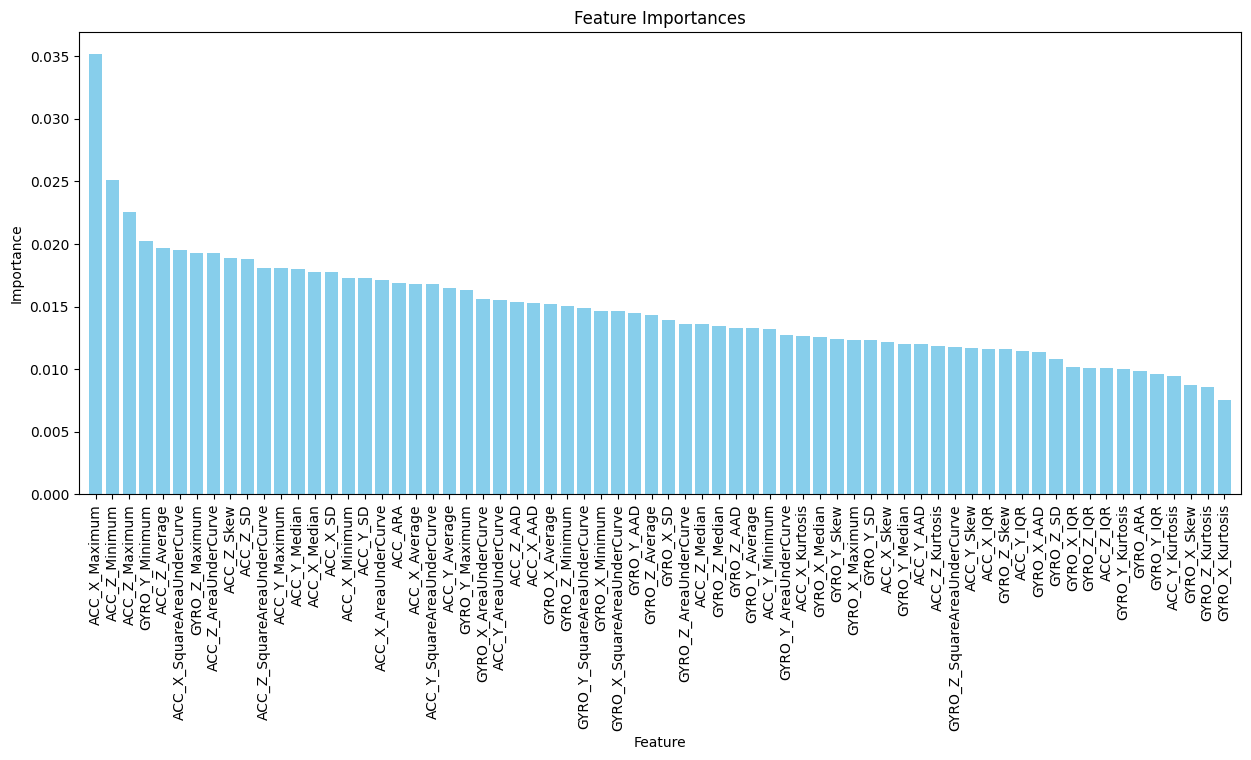

In [339]:
plt.figure(figsize=(15, 6))
plt.title("Feature Importances")
plt.bar(range(windowed_features_data_df.iloc[:, :-4].shape[1]), importances[indices], color="skyblue", align="center")
plt.xticks(range(windowed_features_data_df.iloc[:, :-4].shape[1]), cols, rotation=90)
plt.xlim([-1, windowed_features_data_df.iloc[:, :-4].shape[1]])
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()

## Train, Validation, Test Split

In [340]:
windowed_features_data_df.head()

,ACC_X_Average,ACC_X_SD,ACC_X_AAD,ACC_X_Maximum,ACC_X_Minimum,ACC_X_Median,ACC_X_Skew,ACC_X_Kurtosis,ACC_X_IQR,ACC_X_AreaUnderCurve,...,GYRO_Z_Kurtosis,GYRO_Z_IQR,GYRO_Z_AreaUnderCurve,GYRO_Z_SquareAreaUnderCurve,ACC_ARA,GYRO_ARA,Window_Number,Label,Subject_ID,Trial_ID
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,0,0
1,-0.370432,0.423219,0.034727,0.216064,-1.072754,-0.259522,-0.349235,-1.360474,0.866699,-36.548120,...,-1.077731,126.793893,-6401.801526,918207.579236,0.996369,105.926670,1,1,1,1
2,-0.009595,0.095466,0.009692,0.000000,-0.959473,0.000000,-9.849371,95.010101,0.000000,-0.399780,...,95.010101,0.000000,0.063613,0.009712,0.009947,0.054421,2,1,0,0
3,-0.360396,0.421026,0.035223,0.216064,-1.072754,-0.249878,-0.389314,-1.321244,0.854431,-35.620585,...,-1.078390,126.793893,-6397.083970,917920.353676,0.992394,107.109063,3,1,1,1
4,-0.019214,0.134497,0.009716,0.000000,-0.961914,0.000000,-6.857161,45.020734,0.000000,-1.360270,...,54.702687,0.000000,0.254453,0.048171,0.019818,0.125011,4,1,0,0


In [341]:
windowed_features_data_df.shape

(239794, 72)

In [342]:
def train_val_test_split(windowed_features_data_df, strategy="train_test_split", random_state=1, test_size=0.1, val_size=0.11, **kwargs):
    Y = windowed_features_data_df['Label']
    le = LabelEncoder()
    Y_string = list(map(str, Y))
    Y_LabelEncoded = le.fit_transform(Y_string)
    if strategy == "train_test_split":
        X = windowed_features_data_df.drop(columns=["Label"])
        X_train, X_test, y_train, y_test = train_test_split(X, Y_LabelEncoded, stratify=Y_LabelEncoded, test_size=test_size, random_state=random_state, shuffle=True)
        print(X_train.shape)
        X_train.drop(columns=['Window_Number', "Trial_ID", "Subject_ID"], inplace=True)
        print(X_train.shape)
        windowed_metadata_df = X_test[['Window_Number', "Trial_ID", "Subject_ID"]]
        X_test.drop(columns=['Window_Number', "Trial_ID", "Subject_ID"], inplace=True)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=val_size, random_state=random_state, shuffle=True)
        return X_train, y_train, X_test, y_test, X_val, y_val, le, windowed_metadata_df
    elif strategy == "leave_one_trial_out":
        unseen_subjects = list(map(int, list(kwargs["unseen_subjects"])))
        unseen_trial = list(map(int, (kwargs["unseen_trial"])))
        if len(unseen_trial) !=1:
            raise Exception("More than 1 trail per Subject not allowed for this train,test split strategy")
        # Create a boolean mask based on the condition
        condition_mask = (windowed_features_data_df["Subject_ID"].isin(unseen_subjects)) & (windowed_features_data_df['Trial_ID'].isin(unseen_trial))

        unseen_data_df = windowed_features_data_df[condition_mask]
        print(unseen_data_df.shape)

        # Drop the rows that satisfy the condition
        train_data_df = windowed_features_data_df.drop(windowed_features_data_df[condition_mask].index)
        X_train = train_data_df.drop(columns=['Window_Number', "Label", "Trial_ID", "Subject_ID"])
        Y_train = train_data_df["Label"]
        Y_train = le.transform(Y_train)
        X_test = unseen_data_df.drop(columns=['Window_Number', "Label", "Trial_ID", "Subject_ID"])
        windowed_metadata_df = unseen_data_df[['Window_Number', "Trial_ID", "Subject_ID"]]
        Y_test = unseen_data_df["Label"]
        y_test = le.transform(Y_test)
        X_train, X_val, y_train, y_val = train_test_split(X_train, Y_train, stratify=Y_train, test_size=val_size, random_state=random_state, shuffle=True)
        return X_train, y_train, X_test, y_test, X_val, y_val, le, windowed_metadata_df
    elif strategy == "leave_two_trial_out":
        unseen_subjects = list(map(int, list(kwargs["unseen_subjects"])))
        unseen_trial = list(map(int, (kwargs["unseen_trial"])))
        if len(unseen_trial) != 2:
            raise Exception("Two Trials expected per subject in unseen data")
        # Create a boolean mask based on the condition
        condition_mask = (windowed_features_data_df["Subject_ID"].isin(unseen_subjects)) & (windowed_features_data_df['Trial_ID'].isin(unseen_trial))

        unseen_data_df = windowed_features_data_df[condition_mask]
        print(unseen_data_df.shape)

        # Drop the rows that satisfy the condition
        train_data_df = windowed_features_data_df.drop(windowed_features_data_df[condition_mask].index)
        X_train = train_data_df.drop(columns=['Window_Number', "Label", "Trial_ID", "Subject_ID"])
        Y_train = train_data_df["Label"]
        Y_train = le.transform(Y_train)
        X_test = unseen_data_df.drop(columns=['Window_Number', "Label", "Trial_ID", "Subject_ID"])
        windowed_metadata_df = unseen_data_df[['Window_Number', "Trial_ID", "Subject_ID"]]
        Y_test = unseen_data_df["Label"]
        y_test = le.transform(Y_test)
        X_train, X_val, y_train, y_val = train_test_split(X_train, Y_train, stratify=Y_train, test_size=val_size, random_state=random_state, shuffle=True)
        return X_train, y_train, X_test, y_test, X_val, y_val, le, windowed_metadata_df
    elif strategy == "kfold":
        X = windowed_features_data_df.drop(columns=['Window_Number', "Label", "Trial_ID", "Subject_ID"])
        X_train, X_test, y_train, y_test = train_test_split(X, Y_LabelEncoded, stratify=Y_LabelEncoded, test_size=test_size, random_state=random_state, shuffle=True)
        skf = StratifiedKFold(n_splits=int(kwargs["n_splits"]), random_state=random_state, shuffle=True)
        return X_train, y_train, X_test, y_test, skf, le
    else:
        raise NotImplementedError("Other Train, Val, Test split strategies are not implemented")

In [343]:
out = train_val_test_split(windowed_features_data_df, strategy="leave_one_trial_out", unseen_subjects = [4, 8], unseen_trial=[1])

(15282, 72)


In [344]:
X_train, y_train, X_test, y_test, X_val, y_val, le, windowed_metadata_df = out

In [345]:
windowed_metadata_df.head()

,Window_Number,Trial_ID,Subject_ID
85225,85225,1,4
85227,85227,1,4
85229,85229,1,4
85231,85231,1,4
85233,85233,1,4


In [346]:
le.classes_

array(['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19',
       '2', '20', '21', '3', '4', '5', '6', '7', '8', '9'], dtype='<U2')

In [347]:
X_train.shape

(199815, 68)

In [348]:
y_train.shape

(199815,)

In [349]:
X_test.shape

(15282, 68)

In [350]:
y_test.shape

(15282,)

In [351]:
X_val.shape

(24697, 68)

In [352]:
y_val.shape

(24697,)

## Scaled Normalization and PCA



In [353]:
# Scale normalization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Apply PCA
pca = PCA(n_components=0.95)  # Choose the number of components to retain 95% of the variance
X_train_pca = pca.fit_transform(X_train_scaled)

# Create a DataFrame for the Scaled and PCA-transformed features
columns = [f'PCA_{i+1}' for i in range(X_train_pca.shape[1])]
X_train_pca_df = pd.DataFrame(X_train_pca, columns=columns)

# Concatenate the window_number and window_activity columns with the scaled and PCA-transformed features
Label = pd.Series(y_train)
Label.name = "Label"
train_df = pd.concat([X_train_pca_df, Label], axis=1)

In [354]:
print(pca.components_)

[[ 0.00473785  0.16682288  0.18443463 ...  0.17482686  0.18400619
   0.21542453]
 [-0.30585894  0.04098969 -0.00083416 ... -0.01708191  0.12897517
  -0.03134984]
 [ 0.09228686  0.03218168  0.07411596 ... -0.10198595 -0.05994471
  -0.05036501]
 ...
 [-0.05754028 -0.08336939  0.10511631 ...  0.04571763  0.06604914
   0.03592591]
 [-0.09031277 -0.11980385  0.03298006 ...  0.02780463 -0.14372719
   0.0180333 ]
 [-0.06019898 -0.05494427  0.07608198 ... -0.03693887 -0.08010331
  -0.02829391]]


In [355]:
print(pca.explained_variance_)

[18.13871477  6.70126005  5.43357827  4.27635235  4.07003682  3.3921346
  2.41207235  2.34366692  2.3123114   1.98449658  1.72525128  1.41394645
  1.23552551  1.18904068  1.12311667  1.01551308  0.88999857  0.73441234
  0.65599844  0.6475415   0.55657684  0.54360436  0.50821054  0.47689716
  0.40207378  0.36787824  0.3024402 ]


In [356]:
print(pca.explained_variance_ratio_)

[0.26674447 0.09854745 0.07990516 0.06288722 0.05985318 0.04988408
 0.03547147 0.03446552 0.03400441 0.02918363 0.02537122 0.02079323
 0.0181694  0.0174858  0.01651634 0.01493394 0.01308815 0.01080013
 0.00964699 0.00952262 0.00818491 0.00799414 0.00747365 0.00701316
 0.00591282 0.00540995 0.00444763]


In [357]:
train_df.shape

(199815, 28)

In [358]:
train_df.head()

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,...,PCA_19,PCA_20,PCA_21,PCA_22,PCA_23,PCA_24,PCA_25,PCA_26,PCA_27,Label
0,0.880680,-4.403183,-1.112696,3.765655,0.853005,0.075690,0.537091,-0.338997,0.650296,-0.578360,...,-1.320986,-0.596694,-0.721421,0.553286,0.173891,0.036434,-0.283115,0.075741,-0.611190,12
1,-3.106149,-2.794726,-1.080174,1.830494,-0.932302,-1.394614,-0.307615,0.791038,0.098027,-0.152479,...,-0.228565,0.633364,-1.026939,0.222770,-0.154648,-0.785070,-0.520871,0.007687,0.229795,1
2,-3.576844,2.661980,0.546653,-1.053623,-1.210570,1.160374,-0.624328,-2.244758,-0.991415,0.550896,...,-0.549224,0.181558,0.820117,-0.260941,-0.138356,0.343557,0.675146,0.775423,0.116709,3
3,-0.634714,-1.366706,-3.778333,2.608976,-1.767482,-0.841691,-0.209399,-1.879984,-1.674921,-1.391290,...,0.501511,0.113446,-0.021441,-0.039214,0.550748,-0.183201,-1.042040,-0.063060,1.184934,15
4,-2.227836,-3.364613,-0.911590,0.358568,-0.040874,1.549716,0.197308,-1.062024,1.148042,1.418916,...,-0.347600,-1.020099,-0.531214,-0.159709,0.029930,0.240446,-0.959940,0.575295,0.232294,0


In [359]:
X_train.shape

(199815, 68)

In [360]:
X_test = scaler.transform(X_test)

In [361]:
X_test = pca.transform(X_test)

In [362]:
X_val = scaler.transform(X_val)
X_val = pca.transform(X_val)

In [363]:
X_test.shape

(15282, 27)

In [364]:
X_val.shape

(24697, 27)

In [365]:
X_test

array([[ 1.47386977e+00, -2.00286780e+00, -2.14238470e+00, ...,
         3.60151218e-03,  9.34260966e-01,  1.38962308e-01],
       [ 1.54839841e+00, -2.01296899e+00, -2.10792623e+00, ...,
         6.87216112e-02,  9.37129414e-01,  1.74979283e-01],
       [ 1.62584781e+00, -2.02955462e+00, -2.07625320e+00, ...,
         1.21837728e-01,  9.45333642e-01,  2.18561426e-01],
       ...,
       [-8.93417754e+00,  7.49041753e+00,  4.06888490e+00, ...,
         2.03196008e+00,  2.43297364e-01,  2.01872623e-01],
       [-4.74787005e+00,  7.25639037e-01,  1.52962116e+00, ...,
        -6.11057483e-01,  2.48988101e-01,  1.93051548e-01],
       [-8.22247324e+00,  1.65952198e+01,  8.48740791e+00, ...,
         3.36134909e+00, -9.64364305e-01,  4.06218265e-01]])

In [366]:
X_train_pca

array([[ 0.88067974, -4.40318311, -1.11269562, ..., -0.28311491,
         0.07574109, -0.61118965],
       [-3.10614924, -2.79472626, -1.08017377, ..., -0.52087076,
         0.00768725,  0.22979549],
       [-3.57684409,  2.66198013,  0.54665311, ...,  0.6751456 ,
         0.77542313,  0.11670917],
       ...,
       [ 2.81306104, -4.55864568, -2.79698639, ..., -0.10918334,
         0.75535342,  0.14529771],
       [ 4.78376867,  0.71504596,  0.14496632, ..., -1.17717239,
        -0.91246542,  0.91771879],
       [ 0.98504303, -4.49261219, -2.56359031, ..., -0.49880925,
        -0.04346847, -1.05012391]])

In [367]:
X_train_pca.shape

(199815, 27)

In [368]:
X_train = X_train_pca.copy()

In [369]:
X_train_df = X_train_pca_df.copy()

In [370]:
columns = [f'PCA_{i+1}' for i in range(X_test.shape[1])]
X_test_df = pd.DataFrame(X_test, columns=columns)

In [371]:
X_test_df.head()

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,...,PCA_18,PCA_19,PCA_20,PCA_21,PCA_22,PCA_23,PCA_24,PCA_25,PCA_26,PCA_27
0,1.473870,-2.002868,-2.142385,-2.648103,-0.915214,2.405756,0.943183,-0.634949,0.911224,2.725398,...,0.805224,-0.706537,0.520317,0.230654,-0.500802,0.296449,-0.463294,0.003602,0.934261,0.138962
1,1.548398,-2.012969,-2.107926,-2.716086,-0.940046,2.384894,0.949369,-0.635175,0.933241,2.701095,...,0.843943,-0.740186,0.594728,0.189584,-0.496064,0.283157,-0.428600,0.068722,0.937129,0.174979
2,1.625848,-2.029555,-2.076253,-2.789484,-0.970850,2.374319,0.950464,-0.644338,0.952326,2.664818,...,0.897820,-0.754501,0.682916,0.144473,-0.492914,0.300151,-0.371331,0.121838,0.945334,0.218561
3,1.677394,-2.027272,-2.057962,-2.844984,-0.985150,2.361450,0.933609,-0.648228,0.966482,2.663141,...,0.897930,-0.797443,0.749271,0.129587,-0.505874,0.288155,-0.347368,0.187634,0.928374,0.237119
4,1.718329,-2.024828,-2.033990,-2.898808,-0.993173,2.343745,0.907573,-0.668748,0.977259,2.675792,...,0.890493,-0.834122,0.813530,0.125587,-0.519850,0.260280,-0.327401,0.236293,0.900943,0.253195


In [372]:
X_val_df = pd.DataFrame(X_val, columns=columns)

In [373]:
X_val_df.head()

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,...,PCA_18,PCA_19,PCA_20,PCA_21,PCA_22,PCA_23,PCA_24,PCA_25,PCA_26,PCA_27
0,0.303363,1.549729,-0.829813,-0.173409,-0.563188,-0.268978,-1.348873,-0.559314,2.341869,-1.661188,...,-1.006150,-0.077129,0.267547,1.144423,-1.001853,0.568673,0.227299,-0.189727,-0.464804,-0.592755
1,5.248742,0.260457,-2.979488,-2.119267,-0.173787,1.120266,2.311505,-0.337782,-1.796663,-0.909454,...,-0.747073,2.401458,-0.695183,-1.159781,-1.067339,0.760467,-0.658052,-0.307170,1.206158,-0.481281
2,7.223180,0.771510,-0.427834,-0.483545,2.399676,-1.084991,0.339857,-2.170912,1.848215,-0.322519,...,-1.074661,-0.804370,-0.171571,0.547993,0.826395,-0.083360,-0.382119,-0.971990,0.552646,0.495064
3,-1.606479,-0.132625,2.127471,-1.670808,-1.599590,3.282036,-1.381012,-2.390724,2.244062,-0.451887,...,1.435415,0.534516,-0.077243,-0.058251,0.947493,0.445268,0.600674,-0.439266,-0.821369,0.458636
4,1.979194,-3.387609,3.151149,-1.627724,-0.642800,-0.064948,-0.649473,-0.405902,0.197247,3.516152,...,0.365815,-0.151037,0.123269,-0.768913,-0.359717,0.233694,-0.469303,-1.352465,0.309069,0.254974


In [374]:
X_train_df.head()

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,...,PCA_18,PCA_19,PCA_20,PCA_21,PCA_22,PCA_23,PCA_24,PCA_25,PCA_26,PCA_27
0,0.880680,-4.403183,-1.112696,3.765655,0.853005,0.075690,0.537091,-0.338997,0.650296,-0.578360,...,0.626560,-1.320986,-0.596694,-0.721421,0.553286,0.173891,0.036434,-0.283115,0.075741,-0.611190
1,-3.106149,-2.794726,-1.080174,1.830494,-0.932302,-1.394614,-0.307615,0.791038,0.098027,-0.152479,...,0.643440,-0.228565,0.633364,-1.026939,0.222770,-0.154648,-0.785070,-0.520871,0.007687,0.229795
2,-3.576844,2.661980,0.546653,-1.053623,-1.210570,1.160374,-0.624328,-2.244758,-0.991415,0.550896,...,0.430355,-0.549224,0.181558,0.820117,-0.260941,-0.138356,0.343557,0.675146,0.775423,0.116709
3,-0.634714,-1.366706,-3.778333,2.608976,-1.767482,-0.841691,-0.209399,-1.879984,-1.674921,-1.391290,...,1.095151,0.501511,0.113446,-0.021441,-0.039214,0.550748,-0.183201,-1.042040,-0.063060,1.184934
4,-2.227836,-3.364613,-0.911590,0.358568,-0.040874,1.549716,0.197308,-1.062024,1.148042,1.418916,...,0.422519,-0.347600,-1.020099,-0.531214,-0.159709,0.029930,0.240446,-0.959940,0.575295,0.232294


In [375]:
X_test.shape

(15282, 27)

## **The Proposed Neural Network (NN) Architecture**
The proposed Neural Network (NN) architecture in the hybrid approach consists of three dense layers followed by a Dense layer for the number of classes for the number of activity categories in the dataset. The architecture is defined as follows:

1. **Fully Connected Layer (128):**
   - First dense layer with 128 neurons.

2. **Fully Connected Layer (64):**
   - Second dense layer with 64 neurons.

3. **Fully Connected Layer (32):**
   - Third dense layer with 32 neurons.

4. **Activation Function:**
   - Leaky ReLU is used as the activation function.

5. **Optimizer:**
   - Adam optimizer is employed.

6. **Batch Size:**
   - Batch size is set to 16.

### Training Process:

- The 12 features computed for each sample window in the dataset serve as input to the neural network.
- The lightweight neural network is trained using these extracted features.



In [376]:
import shutil
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU
from keras.optimizers import Adam
from keras.callbacks import Callback
from sklearn.metrics import f1_score, accuracy_score
from tensorflow import keras
import tensorflow as tf
from sklearn.metrics import classification_report

In [377]:
def create_model():
    # Define the neural network architecture
    model = Sequential()
    model.add(Dense(256, input_dim=X_train.shape[1], kernel_regularizer=keras.regularizers.l2(0.01)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(128, kernel_regularizer=keras.regularizers.l2(0.01)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(64, kernel_regularizer=keras.regularizers.l2(0.01)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(len(le.classes_), activation='softmax'))  # Output layer
    # Compile the model
    model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.01), metrics=['accuracy'])
    return model

In [378]:
class Metrics_Callback(Callback):
    def __init__(self, validation_data=()):
        super(Callback, self).__init__()
        self.validation_data = validation_data
    def on_train_begin(self, logs={}):
      self.history = {"val_f1":[]}
    def on_epoch_end(self, epoch, logs={}):
        if self.validation_data:
            x_val, y_val = self.validation_data
            y_pred = self.model.predict(x_val)
            y_pred = np.argmax(y_pred, axis=1)
            f1 = f1_score(y_val, y_pred, average='macro')  # Change 'average' parameter as needed
            self.history["val_f1"].append(f1)
            logs['val_f1'] = f1

In [379]:
f1_callback = Metrics_Callback(validation_data=(X_val, y_val))

In [380]:
early_stop_cb = keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=20, verbose=1,
    mode='auto'
)

In [381]:
reduce_lr_cb = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=10, verbose=1,
    mode='auto', min_delta=0.0001, cooldown=5, min_lr=0,
)

In [382]:
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "training/cp-{epoch:04d}.ckpt", monitor='val_loss', verbose=1, save_best_only=False,
    save_weights_only=True, mode='auto',save_freq=10 * 16
)

In [383]:
best_checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "training/best_weight.ckpt", monitor='val_loss', verbose=1, save_best_only=True,
    save_weights_only=True, mode='auto'
)

In [384]:
os.getcwd()

'/Users/priyanshutuli/Desktop/UTD_MHAD_DNN'

In [385]:
try:
    shutil.rmtree("./training/")
except FileNotFoundError:
    print("Training Folder of Checkpoints is not present")
    pass
try:
    os.remove("./Actual_test_data.csv")
except FileNotFoundError:
    print("Actual test data file is not present")
try:
    os.remove("./Predicted_test_data.csv")
except FileNotFoundError:
    print("Predicted test data file is not present")

In [386]:
# Train the model
batch_size = 16
epochs = 100
model = create_model()
train_history = model.fit(X_train, y_train, validation_data =(X_val, y_val), batch_size=batch_size, epochs=epochs, verbose=0, callbacks=[reduce_lr_cb,
                                                                                                                            f1_callback, checkpoint_cb,
                                                                                                                            best_checkpoint_cb])


Epoch 1: saving model to training/cp-0001.ckpt

Epoch 1: saving model to training/cp-0001.ckpt

Epoch 1: saving model to training/cp-0001.ckpt

Epoch 1: saving model to training/cp-0001.ckpt

Epoch 1: saving model to training/cp-0001.ckpt

Epoch 1: saving model to training/cp-0001.ckpt

Epoch 1: saving model to training/cp-0001.ckpt

Epoch 1: saving model to training/cp-0001.ckpt

Epoch 1: saving model to training/cp-0001.ckpt

Epoch 1: saving model to training/cp-0001.ckpt

Epoch 1: saving model to training/cp-0001.ckpt

Epoch 1: saving model to training/cp-0001.ckpt

Epoch 1: saving model to training/cp-0001.ckpt

Epoch 1: saving model to training/cp-0001.ckpt

Epoch 1: saving model to training/cp-0001.ckpt

Epoch 1: saving model to training/cp-0001.ckpt

Epoch 1: saving model to training/cp-0001.ckpt

Epoch 1: saving model to training/cp-0001.ckpt

Epoch 1: saving model to training/cp-0001.ckpt

Epoch 1: saving model to training/cp-0001.ckpt

Epoch 1: saving model to training/cp-00

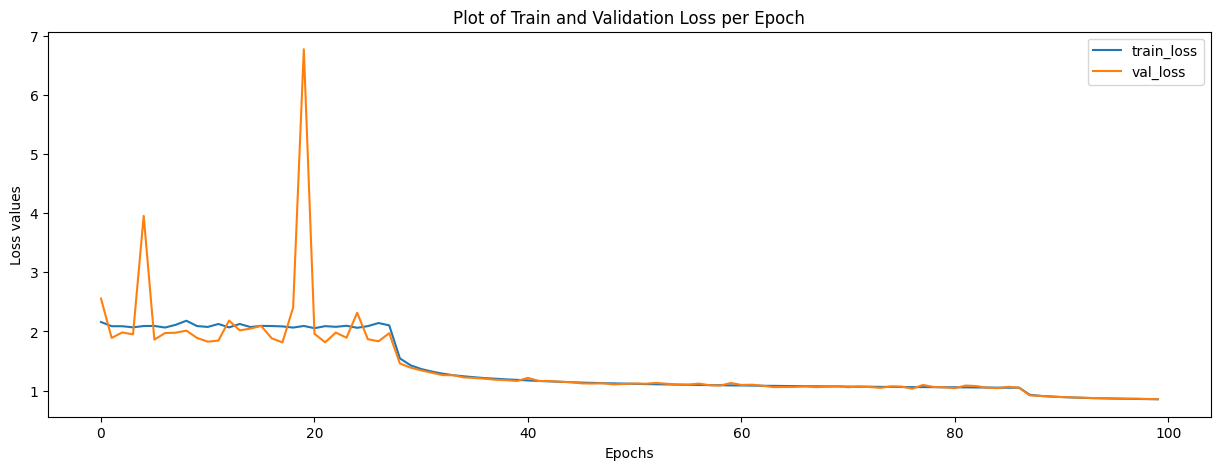

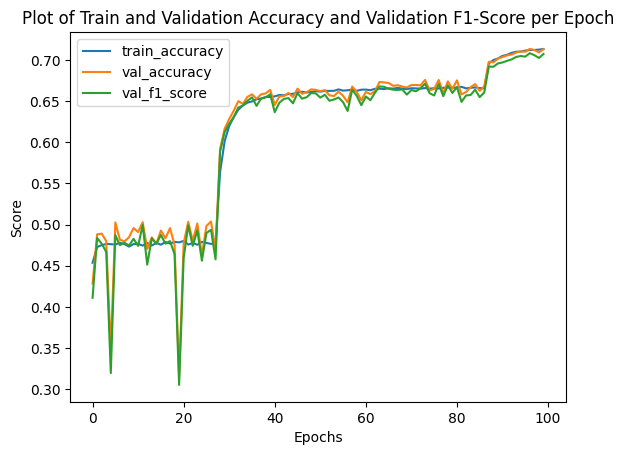

In [387]:
train_loss = train_history.history['loss']
val_loss = train_history.history['val_loss']
train_accuracy = train_history.history["accuracy"]
val_accuracy = train_history.history["val_accuracy"]
val_f1_score = train_history.history["val_f1"]

plt.figure(figsize=(15,5))
plt.plot(train_loss)
plt.plot(val_loss)
plt.xlabel("Epochs")
plt.ylabel("Loss values")
plt.title("Plot of Train and Validation Loss per Epoch")
plt.legend(['train_loss', 'val_loss'])
plt.show()
print()
plt.plot(train_accuracy)
plt.plot(val_accuracy)
plt.plot(val_f1_score)
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.title("Plot of Train and Validation Accuracy and Validation F1-Score per Epoch")
plt.legend(["train_accuracy", "val_accuracy", "val_f1_score"])
plt.show()

In [388]:
min_loss_epoch = np.argmin(train_history.history["val_loss"])
min_loss_epoch

99

In [389]:
min(train_history.history["val_loss"])

0.854864239692688

In [390]:
max(train_history.history["val_f1"])

0.7080343542596813

In [391]:
max(train_history.history["val_accuracy"])

0.713204026222229

## Test Accuracy using Min Validation Loss Epoch on Window Level

In [392]:
# Evaluate the model on the test set
checkpoint_path =f"./training/best_weight.ckpt"
model.load_weights(checkpoint_path)
accuracy = model.evaluate(X_test, y_test)[1]
print(f"Test Accuracy: {accuracy}")

478/478 [==============================] - 0s 428us/step - loss: 1.3101 - accuracy: 0.5946
Test Accuracy: 0.594555675983429


## Test Accuracy using Random Epoch on Window Level

In [393]:
# # Evaluate the model on the test set
# checkpoint_path =f"./training/cp-{98:04d}.ckpt"
# model.load_weights(checkpoint_path)
# accuracy = model.evaluate(X_test, y_test)[1]
# print(f"Test Accuracy: {accuracy}")

## Test Accuracy at Datapoint Level

In [394]:
len(le.classes_)

21

In [395]:
def custom_accuracy_at_datapoint_level(df_actual, df_predicted, le, strategy="multi_label"):
    merged_df = pd.merge(df_actual, df_predicted, on=['Subject_ID','Trial_ID','Window_Number'], how='left')
    
    y_actual = np.array(merged_df['Label'])
    y_predicted = np.array(merged_df['Predicted_Label'])

    if strategy == "bidirectional_windowing":
        pass
    else:
        y_predicted_classes = list(map(str, le.inverse_transform(y_predicted)))
        for pred_class in set(y_predicted_classes):
            if "_" in pred_class:
                pred_class_dp = [y_pred for y_pred in y_predicted_classes if y_pred == pred_class]
                total_dp = len(pred_class_dp)
                label1 = str(pred_class.split("_")[0])
                label2 = str(pred_class.split("_")[1])
                pred_class_dp[0: total_dp // 2] =[label1] * (total_dp // 2)
                pred_class_dp[total_dp // 2:] = [label2] * (total_dp - (total_dp // 2))
                counter = 0
                for i, y_pred in enumerate(y_predicted_classes):
                    if y_pred == pred_class:
                        y_predicted_classes[i] = pred_class_dp[counter]
                        counter+=1
        y_predicted = le.transform(y_predicted_classes)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_actual, y_predicted)
    
    # Calculate F1 score
    f1 = f1_score(y_actual, y_predicted, average='weighted')
    
    
    # Generate a classification report
    # if strategy == "bidirectional_windowing":
    #     test_classes = set(map(str, y_actual))
    # else:   
    #     test_classes = set(map(str, le.inverse_transform(y_predicted)))
    # report = classification_report(y_actual, y_predicted, target_names=test_classes)
    # print(report)
    
    return accuracy, f1

In [396]:
windowed_metadata_df.shape

(15282, 3)

In [397]:
df_actual = pd.concat([windowed_metadata_df.reset_index(drop=True), pd.DataFrame(y_test, columns=["Label"])], axis=1,)

In [398]:
y_test

array([ 0,  0,  0, ..., 13, 13, 13])

In [399]:
df_actual.head()

,Window_Number,Trial_ID,Subject_ID,Label
0,85225,1,4,0
1,85227,1,4,0
2,85229,1,4,0
3,85231,1,4,0
4,85233,1,4,0


In [400]:
UTD1_dataset_with_window_number.head()

,ACC_X,ACC_Y,ACC_Z,GYRO_X,GYRO_Y,GYRO_Z,Activity_ID,Subject_ID,Trial_ID,Window_Number
0,-0.959473,-0.177734,-0.192871,5.221374,1.526718,0.152672,1,1,1,0
0,-0.959473,-0.177734,-0.192871,5.221374,1.526718,0.152672,1,1,1,1
1,-0.961914,-0.153320,-0.159912,6.778626,1.954198,0.244275,1,1,1,2
1,-0.961914,-0.153320,-0.159912,6.778626,1.954198,0.244275,1,1,1,3
2,-0.974609,-0.152832,-0.145996,11.267176,3.175573,1.099237,1,1,1,4


In [401]:
df_actual.shape

(15282, 4)

In [402]:
df_actual["Window_Number"].unique()

array([ 85225,  85227,  85229, ..., 215329, 215330, 215331])

In [403]:
result1 = pd.merge(UTD1_dataset_with_window_number, df_actual, on=["Window_Number","Trial_ID","Subject_ID"], how="inner")

In [404]:
result1.shape

(15282, 11)

In [405]:
result1.head()

,ACC_X,ACC_Y,ACC_Z,GYRO_X,GYRO_Y,GYRO_Z,Activity_ID,Subject_ID,Trial_ID,Window_Number,Label
0,-0.989746,-0.216064,0.196045,-4.946565,-0.183206,-0.824427,1,4,1,85225,0
1,-0.994629,-0.212158,0.200439,-5.770992,-0.916031,-0.091603,1,4,1,85227,0
2,-0.991943,-0.207764,0.195557,-5.923664,-1.129771,0.030534,1,4,1,85229,0
3,-0.985107,-0.208252,0.189209,-5.251908,-0.793893,-0.427481,1,4,1,85231,0
4,-0.983887,-0.211914,0.196045,-5.374046,-0.335878,-0.335878,1,4,1,85233,0


In [406]:
result1.isna().sum()

ACC_X            0
ACC_Y            0
ACC_Z            0
GYRO_X           0
GYRO_Y           0
GYRO_Z           0
Activity_ID      0
Subject_ID       0
Trial_ID         0
Window_Number    0
Label            0
dtype: int64

In [407]:
df_actual = result1.copy()

In [408]:
X_test

array([[ 1.47386977e+00, -2.00286780e+00, -2.14238470e+00, ...,
         3.60151218e-03,  9.34260966e-01,  1.38962308e-01],
       [ 1.54839841e+00, -2.01296899e+00, -2.10792623e+00, ...,
         6.87216112e-02,  9.37129414e-01,  1.74979283e-01],
       [ 1.62584781e+00, -2.02955462e+00, -2.07625320e+00, ...,
         1.21837728e-01,  9.45333642e-01,  2.18561426e-01],
       ...,
       [-8.93417754e+00,  7.49041753e+00,  4.06888490e+00, ...,
         2.03196008e+00,  2.43297364e-01,  2.01872623e-01],
       [-4.74787005e+00,  7.25639037e-01,  1.52962116e+00, ...,
        -6.11057483e-01,  2.48988101e-01,  1.93051548e-01],
       [-8.22247324e+00,  1.65952198e+01,  8.48740791e+00, ...,
         3.36134909e+00, -9.64364305e-01,  4.06218265e-01]])

In [409]:
y_pred = np.argmax(model.predict(X_test), axis=1)

478/478 [==============================] - 0s 369us/step


In [410]:
df_predicted = pd.concat([windowed_metadata_df.reset_index(drop=True), pd.DataFrame(y_pred, columns=["Predicted_Label"])], axis=1)

In [411]:
df_predicted.head()

,Window_Number,Trial_ID,Subject_ID,Predicted_Label
0,85225,1,4,0
1,85227,1,4,0
2,85229,1,4,0
3,85231,1,4,0
4,85233,1,4,0


In [412]:
df_predicted = pd.merge(UTD1_dataset_with_window_number, df_predicted, on=["Window_Number","Trial_ID","Subject_ID"], how="inner")

In [413]:
df_predicted.shape

(15282, 11)

In [414]:
df_predicted.head()

,ACC_X,ACC_Y,ACC_Z,GYRO_X,GYRO_Y,GYRO_Z,Activity_ID,Subject_ID,Trial_ID,Window_Number,Predicted_Label
0,-0.989746,-0.216064,0.196045,-4.946565,-0.183206,-0.824427,1,4,1,85225,0
1,-0.994629,-0.212158,0.200439,-5.770992,-0.916031,-0.091603,1,4,1,85227,0
2,-0.991943,-0.207764,0.195557,-5.923664,-1.129771,0.030534,1,4,1,85229,0
3,-0.985107,-0.208252,0.189209,-5.251908,-0.793893,-0.427481,1,4,1,85231,0
4,-0.983887,-0.211914,0.196045,-5.374046,-0.335878,-0.335878,1,4,1,85233,0


In [415]:
df_actual.head()

,ACC_X,ACC_Y,ACC_Z,GYRO_X,GYRO_Y,GYRO_Z,Activity_ID,Subject_ID,Trial_ID,Window_Number,Label
0,-0.989746,-0.216064,0.196045,-4.946565,-0.183206,-0.824427,1,4,1,85225,0
1,-0.994629,-0.212158,0.200439,-5.770992,-0.916031,-0.091603,1,4,1,85227,0
2,-0.991943,-0.207764,0.195557,-5.923664,-1.129771,0.030534,1,4,1,85229,0
3,-0.985107,-0.208252,0.189209,-5.251908,-0.793893,-0.427481,1,4,1,85231,0
4,-0.983887,-0.211914,0.196045,-5.374046,-0.335878,-0.335878,1,4,1,85233,0


In [416]:
df_actual.reset_index(inplace=True)

In [417]:
df_actual.head()

,index,ACC_X,ACC_Y,ACC_Z,GYRO_X,GYRO_Y,GYRO_Z,Activity_ID,Subject_ID,Trial_ID,Window_Number,Label
0,0,-0.989746,-0.216064,0.196045,-4.946565,-0.183206,-0.824427,1,4,1,85225,0
1,1,-0.994629,-0.212158,0.200439,-5.770992,-0.916031,-0.091603,1,4,1,85227,0
2,2,-0.991943,-0.207764,0.195557,-5.923664,-1.129771,0.030534,1,4,1,85229,0
3,3,-0.985107,-0.208252,0.189209,-5.251908,-0.793893,-0.427481,1,4,1,85231,0
4,4,-0.983887,-0.211914,0.196045,-5.374046,-0.335878,-0.335878,1,4,1,85233,0


In [418]:
df_predicted.reset_index(inplace=True)

In [419]:
df_predicted.head()

,index,ACC_X,ACC_Y,ACC_Z,GYRO_X,GYRO_Y,GYRO_Z,Activity_ID,Subject_ID,Trial_ID,Window_Number,Predicted_Label
0,0,-0.989746,-0.216064,0.196045,-4.946565,-0.183206,-0.824427,1,4,1,85225,0
1,1,-0.994629,-0.212158,0.200439,-5.770992,-0.916031,-0.091603,1,4,1,85227,0
2,2,-0.991943,-0.207764,0.195557,-5.923664,-1.129771,0.030534,1,4,1,85229,0
3,3,-0.985107,-0.208252,0.189209,-5.251908,-0.793893,-0.427481,1,4,1,85231,0
4,4,-0.983887,-0.211914,0.196045,-5.374046,-0.335878,-0.335878,1,4,1,85233,0


In [420]:
df_actual.to_csv("Actual_test_data.csv", index=False)

In [421]:
df_predicted.to_csv("Predicted_test_data.csv", index=False)

In [422]:
dp_accuracy, dp_f1_score = custom_accuracy_at_datapoint_level(df_actual=df_actual, df_predicted=df_predicted, le=le, strategy="bidirectional_windowing")

In [423]:
dp_accuracy

0.594555686428478

In [424]:
dp_f1_score

0.5935260161834165

In [425]:
# dp_classification_report

## Classification Report

In [426]:
# Convert label_encoder.classes_ to a list of strings
target_names = list(le.classes_)

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Generate the classification report
report = classification_report(y_test, y_pred, target_names=target_names)

print(report)

  1/478 [..............................] - ETA: 6s

478/478 [==============================] - 0s 391us/step
              precision    recall  f1-score   support

           1       0.68      0.64      0.66       484
          10       0.59      0.67      0.63       750
          11       0.79      0.57      0.66       802
          12       0.60      0.76      0.67       878
          13       0.72      0.63      0.67       792
          14       0.56      0.69      0.62       826
          15       0.69      0.60      0.64       844
          16       0.55      0.51      0.53       748
          17       0.50      0.52      0.51       834
          18       0.70      0.35      0.47       694
          19       0.71      0.64      0.67       738
           2       0.55      0.57      0.56       584
          20       0.46      0.38      0.41       650
          21       0.62      0.71      0.66      1032
           3       0.58      0.63      0.60       638
           4       0.62      0.52      0.56       662
           5       0.35 

## Confusion Matrix

478/478 [==============================] - 0s 449us/step


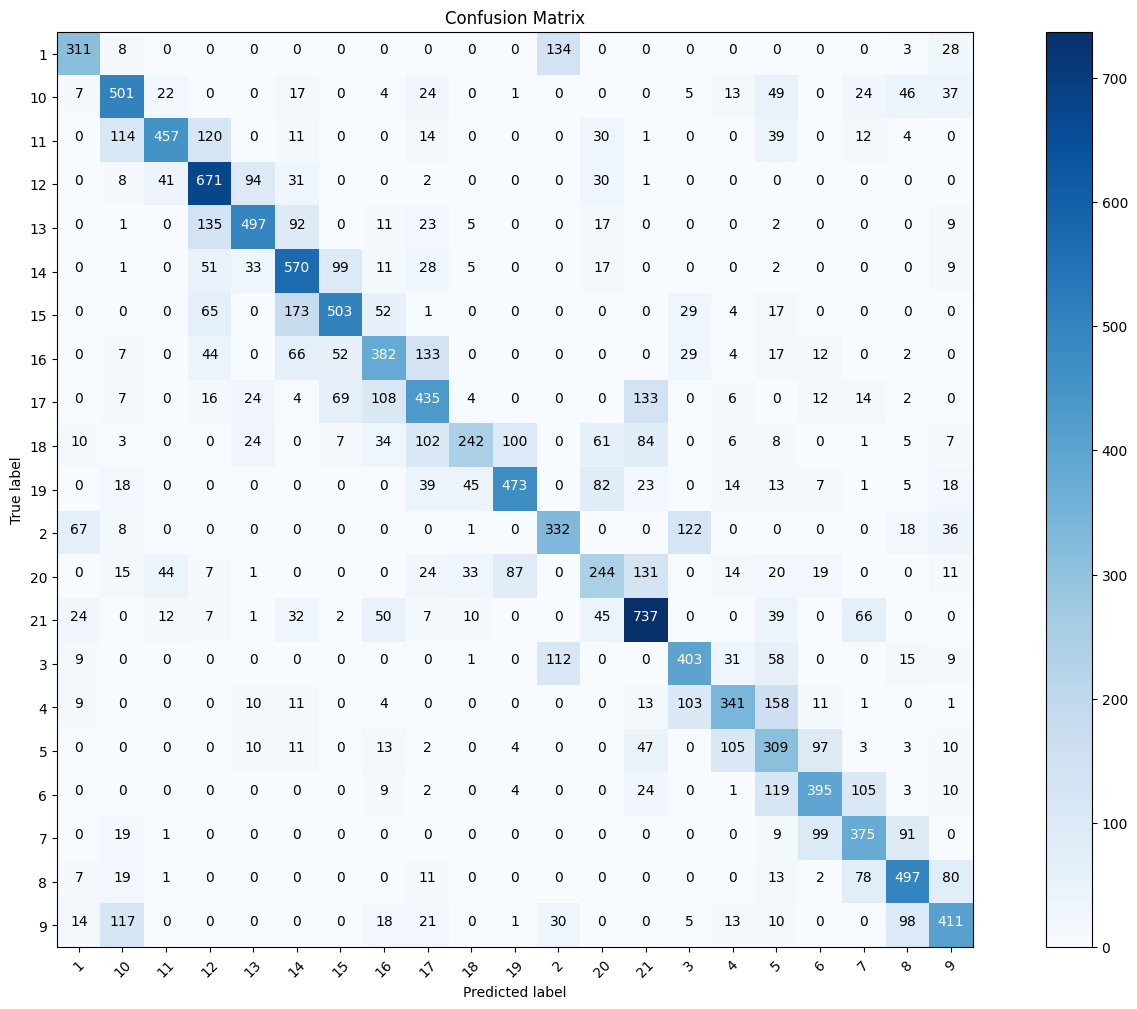

In [427]:
from sklearn.metrics import confusion_matrix

# Predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)


# Create confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)


classes = list(le.classes_)
tick_marks = np.arange(len(classes))


plt.figure(figsize=(15, 10))
plt.imshow(cm, cmap='Blues', interpolation="nearest")
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Show the values in the plot
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()
plt.show()

## Feature Importance Using Permutation Importance

In [428]:
from sklearn.inspection import permutation_importance

In [429]:
def score(model, X,y):
    _, accuracy = model.evaluate(X, y, verbose=0)
    return accuracy

In [430]:
r = permutation_importance(model, X_test, y_test,n_repeats=30,random_state=0, scoring=score)

In [431]:
cols = windowed_features_data_df.drop(columns=['Window_Number', "Trial_ID", "Subject_ID", "Label"]).columns

In [432]:
columns = [f'PCA_{i+1}' for i in range(X_train_pca.shape[1])]
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{columns[i]:<8}"
              f" {r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

PCA_1    0.189 +/- 0.002
PCA_2    0.173 +/- 0.003
PCA_3    0.126 +/- 0.002
PCA_6    0.123 +/- 0.003
PCA_10   0.104 +/- 0.002
PCA_5    0.093 +/- 0.002
PCA_4    0.079 +/- 0.002
PCA_7    0.077 +/- 0.002
PCA_8    0.074 +/- 0.003
PCA_9    0.071 +/- 0.002
PCA_12   0.062 +/- 0.002
PCA_15   0.059 +/- 0.002
PCA_13   0.058 +/- 0.002
PCA_14   0.035 +/- 0.002
PCA_20   0.034 +/- 0.001
PCA_19   0.033 +/- 0.002
PCA_11   0.031 +/- 0.002
PCA_21   0.029 +/- 0.002
PCA_18   0.027 +/- 0.002
PCA_26   0.024 +/- 0.001
PCA_17   0.022 +/- 0.002
PCA_16   0.021 +/- 0.002
PCA_24   0.019 +/- 0.002
PCA_25   0.015 +/- 0.001
PCA_22   0.013 +/- 0.001
PCA_23   0.013 +/- 0.001
PCA_27   0.012 +/- 0.001


In [433]:
r.importances

array([[0.19153252, 0.18747544, 0.18871874, 0.18597043, 0.18741003,
        0.18551236, 0.18930766, 0.18557778, 0.18904594, 0.19113991,
        0.19015834, 0.18799895, 0.18695197, 0.18610129, 0.18858787,
        0.1836147 , 0.19048554, 0.18858787, 0.1891768 , 0.192056  ,
        0.18950397, 0.18590498, 0.19166338, 0.18930766, 0.18734458,
        0.19329929, 0.19212145, 0.19002748, 0.18557778, 0.1906164 ],
       [0.17504251, 0.17739823, 0.17563146, 0.16810626, 0.16823712,
        0.17124721, 0.17249051, 0.17412642, 0.17321029, 0.17438817,
        0.17255592, 0.17294857, 0.17347205, 0.16686296, 0.17425728,
        0.16902238, 0.17563146, 0.16954586, 0.17006937, 0.17314488,
        0.17883784, 0.17334118, 0.16954586, 0.17635125, 0.1722942 ,
        0.17445359, 0.17765999, 0.17177069, 0.17602408, 0.17916501],
       [0.12406752, 0.12491819, 0.12517995, 0.12537625, 0.12563801,
        0.12949875, 0.12589973, 0.12714303, 0.12400207, 0.12374035,
        0.12635779, 0.12557256, 0.12825546, 0.

In [434]:
r.importances_mean

array([0.18869257, 0.17322775, 0.12638615, 0.0787266 , 0.09349343,
       0.12348295, 0.07676569, 0.0736858 , 0.07054049, 0.10389346,
       0.03083147, 0.06187889, 0.05828642, 0.03473584, 0.05924398,
       0.02079133, 0.02190812, 0.02736115, 0.0325699 , 0.03406621,
       0.02917593, 0.01349953, 0.01330758, 0.0185425 , 0.01530122,
       0.02382104, 0.0124351 ])

In [435]:
r.importances_std

array([0.00234853, 0.0031379 , 0.00214113, 0.00246754, 0.00216248,
       0.00277793, 0.00242514, 0.00278377, 0.00205148, 0.00205615,
       0.00221939, 0.00234834, 0.00218797, 0.0022039 , 0.00195131,
       0.00177653, 0.00201246, 0.00195688, 0.00225934, 0.00148976,
       0.00159883, 0.00121227, 0.00136086, 0.00154634, 0.00148038,
       0.00145336, 0.00097344])

In [436]:
importance_scores = r.importances_mean

In [437]:
importance_std = r.importances_std

In [438]:
importance_std

array([0.00234853, 0.0031379 , 0.00214113, 0.00246754, 0.00216248,
       0.00277793, 0.00242514, 0.00278377, 0.00205148, 0.00205615,
       0.00221939, 0.00234834, 0.00218797, 0.0022039 , 0.00195131,
       0.00177653, 0.00201246, 0.00195688, 0.00225934, 0.00148976,
       0.00159883, 0.00121227, 0.00136086, 0.00154634, 0.00148038,
       0.00145336, 0.00097344])

In [439]:
component_importance = {}
component_std = {}
for i, (component, importance) in enumerate(zip(pca.components_, pca.explained_variance_ratio_)):
    feature_importance = np.abs(component) * importance
    for j, feature in enumerate(cols):
        if feature not in component_importance:
            component_importance[feature] = 0
        if feature not in component_std:
            component_std[feature] = 0
        component_importance[feature] += feature_importance[j] * importance_scores[i]
        component_std[feature] += feature_importance[j] * importance_std[i]

In [440]:
component_importance

{'ACC_X_Average': 0.009000178796420531,
 'ACC_X_SD': 0.013113195151142402,
 'ACC_X_AAD': 0.012852764779100093,
 'ACC_X_Maximum': 0.011912723783008786,
 'ACC_X_Minimum': 0.013964376265262049,
 'ACC_X_Median': 0.009714625465465657,
 'ACC_X_Skew': 0.010627617503247602,
 'ACC_X_Kurtosis': 0.00940560542679301,
 'ACC_X_IQR': 0.01126074785370288,
 'ACC_X_AreaUnderCurve': 0.009032515473781401,
 'ACC_X_SquareAreaUnderCurve': 0.012669128837154616,
 'ACC_Y_Average': 0.009015043905248364,
 'ACC_Y_SD': 0.014297860375619972,
 'ACC_Y_AAD': 0.013256064931148046,
 'ACC_Y_Maximum': 0.01252383826026659,
 'ACC_Y_Minimum': 0.011491524934239364,
 'ACC_Y_Median': 0.00816491862877752,
 'ACC_Y_Skew': 0.008016629550141348,
 'ACC_Y_Kurtosis': 0.007361434082707636,
 'ACC_Y_IQR': 0.012498695615503402,
 'ACC_Y_AreaUnderCurve': 0.009025719872415842,
 'ACC_Y_SquareAreaUnderCurve': 0.012834760620415253,
 'ACC_Z_Average': 0.011314946470429922,
 'ACC_Z_SD': 0.013393112793093782,
 'ACC_Z_AAD': 0.013860933109428063,
 'ACC

In [441]:
len(component_importance)

68

In [442]:
sorted_component_importance = dict(sorted(component_importance.items(), key= lambda item: item[1], reverse=True))

In [443]:
component_std

{'ACC_X_Average': 0.00019000127789018924,
 'ACC_X_SD': 0.00023424258691878932,
 'ACC_X_AAD': 0.000220741612526489,
 'ACC_X_Maximum': 0.00022498960564782642,
 'ACC_X_Minimum': 0.00024557446943998144,
 'ACC_X_Median': 0.00020814739821168953,
 'ACC_X_Skew': 0.00022426257975388731,
 'ACC_X_Kurtosis': 0.00021099092976781554,
 'ACC_X_IQR': 0.00021706297466598577,
 'ACC_X_AreaUnderCurve': 0.00019054323134506574,
 'ACC_X_SquareAreaUnderCurve': 0.000240654752365165,
 'ACC_Y_Average': 0.00021489219646361036,
 'ACC_Y_SD': 0.00024849473835379877,
 'ACC_Y_AAD': 0.0002116823814587525,
 'ACC_Y_Maximum': 0.00022982910602809673,
 'ACC_Y_Minimum': 0.00021387264560946784,
 'ACC_Y_Median': 0.0002109443191188633,
 'ACC_Y_Skew': 0.00019413364886825327,
 'ACC_Y_Kurtosis': 0.0001796437543074088,
 'ACC_Y_IQR': 0.00023751536152782067,
 'ACC_Y_AreaUnderCurve': 0.00021505672430162368,
 'ACC_Y_SquareAreaUnderCurve': 0.00023903600135129162,
 'ACC_Z_Average': 0.00022557917067315427,
 'ACC_Z_SD': 0.000227348965389229

In [444]:
combined_component_importance = {}
for key, value in sorted_component_importance.items():
    combined_component_importance[key] = f"{value} +- {component_std[key]}"

In [445]:
combined_component_importance

{'ACC_ARA': '0.014450627920122696 +- 0.00023666801670856969',
 'ACC_Y_SD': '0.014297860375619972 +- 0.00024849473835379877',
 'GYRO_Y_Minimum': '0.014265920165797735 +- 0.0002474105101846949',
 'ACC_X_Minimum': '0.013964376265262049 +- 0.00024557446943998144',
 'ACC_Z_AAD': '0.013860933109428063 +- 0.0002461127830269291',
 'GYRO_Z_AAD': '0.013688666419995802 +- 0.00022067654646826476',
 'GYRO_Y_AAD': '0.013639746764639152 +- 0.00021940099293167673',
 'GYRO_Z_SD': '0.013627260254411057 +- 0.00023352424531751861',
 'ACC_Z_Maximum': '0.013619758801131742 +- 0.0002419355002953897',
 'GYRO_X_SD': '0.01344024339125588 +- 0.00023202959190989414',
 'GYRO_ARA': '0.01342427980898527 +- 0.0002045983672299908',
 'ACC_Z_SD': '0.013393112793093782 +- 0.00022734896538922987',
 'ACC_Z_SquareAreaUnderCurve': '0.013270429948426322 +- 0.00023555884468081758',
 'GYRO_Z_SquareAreaUnderCurve': '0.01325696985058856 +- 0.0002304359017896226',
 'ACC_Y_AAD': '0.013256064931148046 +- 0.0002116823814587525',
 'AC

In [446]:
combined_component_importance_df = pd.DataFrame(combined_component_importance, index=[0])

In [447]:
combined_component_importance_df.head()

,ACC_ARA,ACC_Y_SD,GYRO_Y_Minimum,ACC_X_Minimum,ACC_Z_AAD,GYRO_Z_AAD,GYRO_Y_AAD,GYRO_Z_SD,ACC_Z_Maximum,GYRO_X_SD,...,ACC_Z_Skew,ACC_Y_Kurtosis,GYRO_X_AreaUnderCurve,GYRO_X_Average,GYRO_X_Skew,GYRO_Z_Median,GYRO_Y_Median,GYRO_Z_Skew,ACC_Z_Kurtosis,GYRO_X_Kurtosis
0,0.014450627920122696 +- 0.00023666801670856969,0.014297860375619972 +- 0.00024849473835379877,0.014265920165797735 +- 0.0002474105101846949,0.013964376265262049 +- 0.00024557446943998144,0.013860933109428063 +- 0.0002461127830269291,0.013688666419995802 +- 0.00022067654646826476,0.013639746764639152 +- 0.00021940099293167673,0.013627260254411057 +- 0.00023352424531751861,0.013619758801131742 +- 0.0002419355002953897,0.01344024339125588 +- 0.00023202959190989414,...,0.007366036967722555 +- 0.00018837332667824598,0.007361434082707636 +- 0.0001796437543074088,0.007259054867013521 +- 0.00018091330595155754,0.007240444412868404 +- 0.0001806351195879124,0.0071514302303753285 +- 0.0001820699553523542,0.007050735035544582 +- 0.00018523585087729135,0.006947219700625309 +- 0.00018225616415292785,0.0067306604578619075 +- 0.00016834453537254319,0.006634275533075569 +- 0.00018457189265176662,0.006335444595180014 +- 0.0001739845483985515


In [448]:
pd.Series(combined_component_importance).reset_index().to_csv("permutation_importance_score.csv")

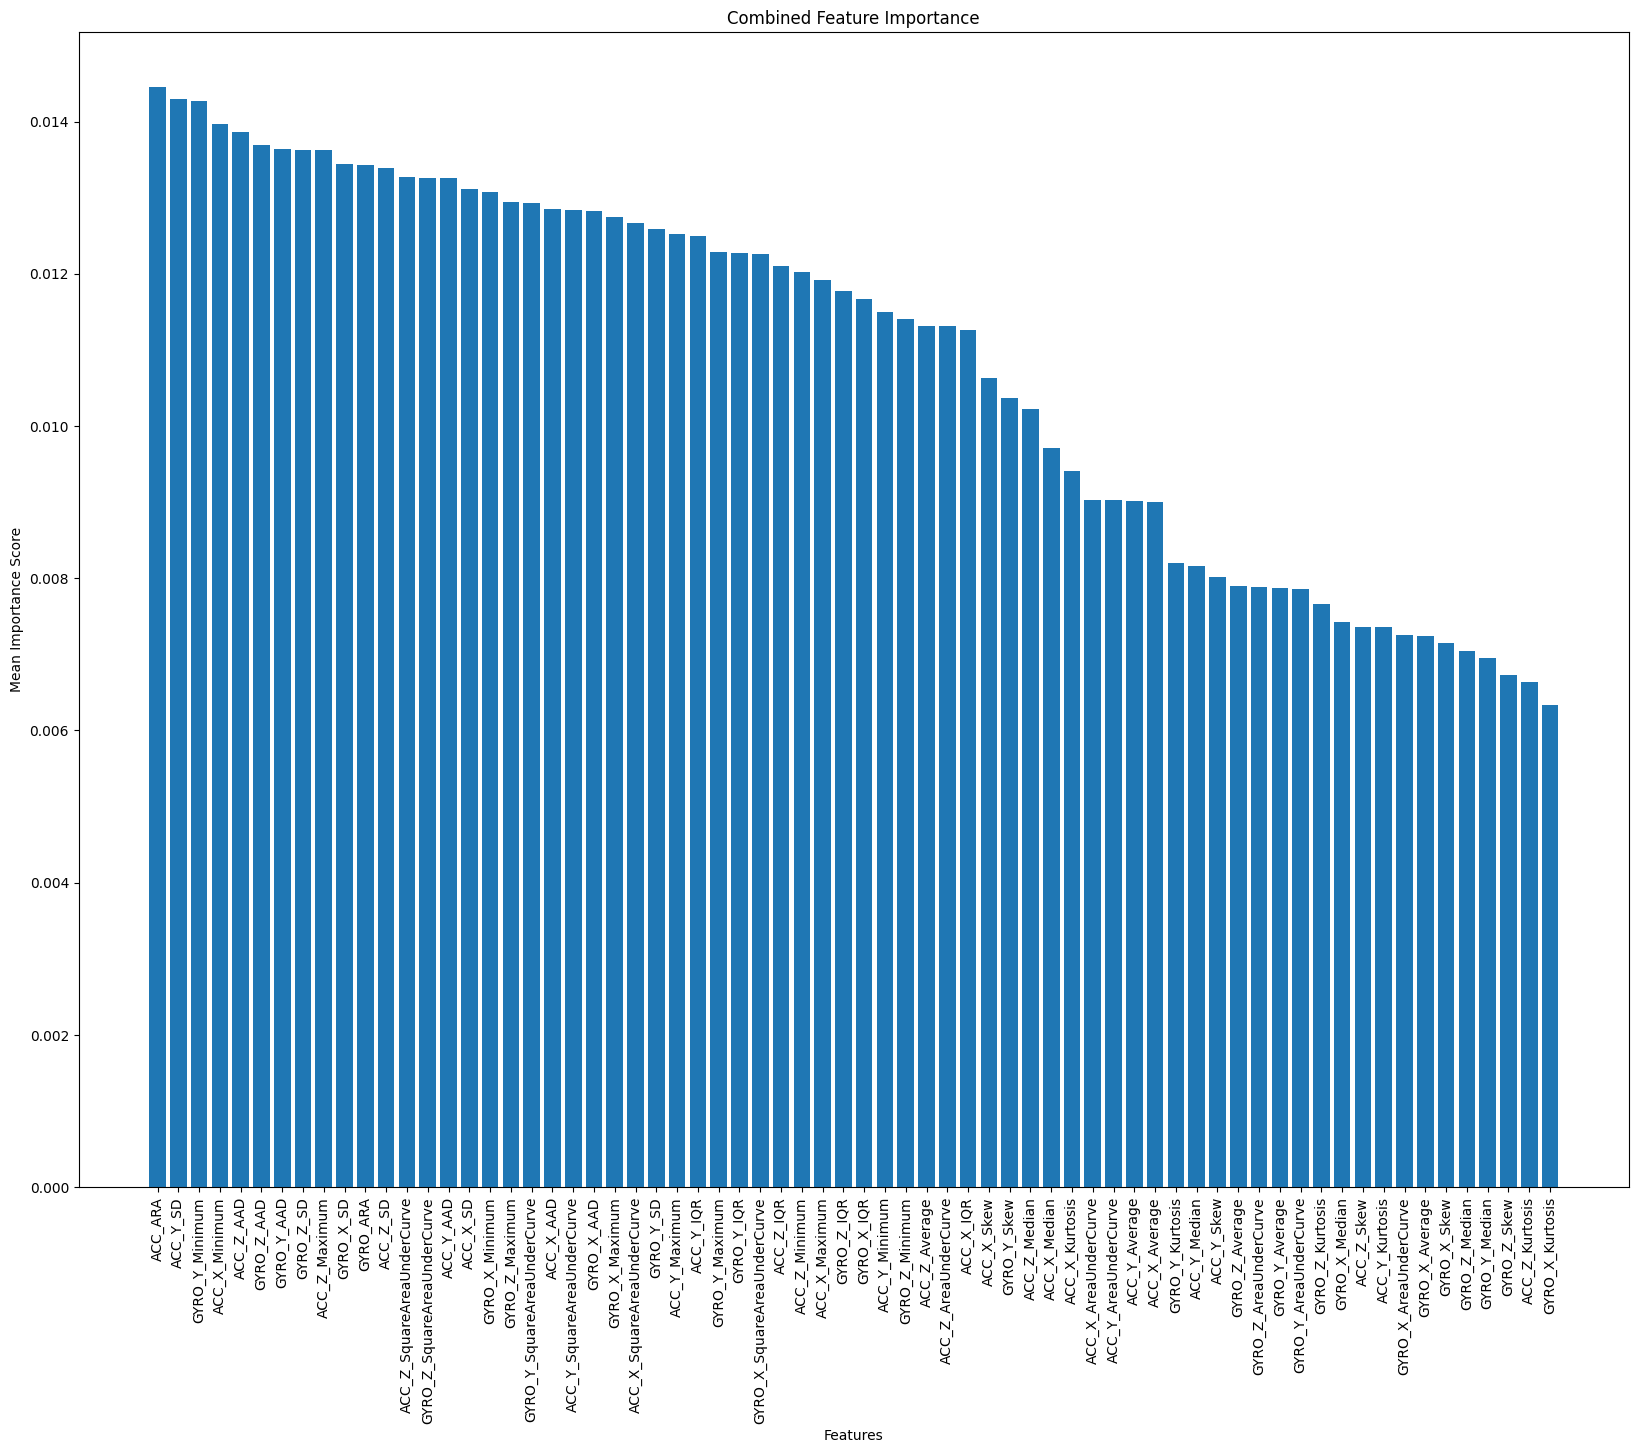

In [449]:
plt.figure(figsize=(20,15))
plt.bar(sorted_component_importance.keys(), sorted_component_importance.values())
plt.xticks(ticks=list(sorted_component_importance.keys()), rotation=90)
plt.xlabel("Features")
plt.ylabel("Mean Importance Score")
plt.title("Combined Feature Importance")
plt.show()

## ML Classification Models

In [498]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
import warnings

# Suppress the convergence warning for Logistic Regression
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

In [485]:
# Initialize and train the models
ml_models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, n_jobs=-1),
    'Support Vector Machine': SVC(decision_function_shape='ovr', kernel='poly'),
    'K-Nearest Neighbors': KNeighborsClassifier(n_jobs=-1, n_neighbors=7, weights='distance'),
    'Logistic Regression': LogisticRegression(multi_class='ovr', max_iter=1000, solver='saga'),
    'Decision Tree': DecisionTreeClassifier()
}


In [493]:
import statistics

In [499]:
from prettytable import PrettyTable

table = PrettyTable()

# Define columns
table.field_names = ["Model", "Validation Accuracy", "Test Accuracy"]

# Add rows for each model's accuracy
for ml_model_name, ml_model in ml_models.items():
    # Train the model
    ml_model.fit(X_train, y_train)
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=5, random_state=1)
    val_accuracy_score = cross_val_score(ml_model, X_val, y_val, cv=cv, scoring="accuracy", n_jobs=-1)
    mean_val_accuracy_score = statistics.mean(val_accuracy_score)
    # Make predictions
    y_pred = ml_model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)

    # Add row to the table
    table.add_row([ml_model_name, f"{mean_val_accuracy_score:.4f}", f"{accuracy:.4f}"])

# Print the table
print(table)


+------------------------+---------------------+---------------+
|         Model          | Validation Accuracy | Test Accuracy |
+------------------------+---------------------+---------------+
|     Random Forest      |        0.6926       |     0.5951    |
| Support Vector Machine |        0.6541       |     0.5648    |
|  K-Nearest Neighbors   |        0.6943       |     0.6158    |
|  Logistic Regression   |        0.4599       |     0.3986    |
|     Decision Tree      |        0.5467       |     0.3803    |
+------------------------+---------------------+---------------+


## BorutaPy Feature Importance

In [453]:
from boruta import BorutaPy

In [454]:
X_boruta = X_train.copy()
y_boruta = y_train.copy()
rf = RandomForestClassifier(n_jobs=-1, n_estimators="auto", oob_score=True, max_depth=20)

np.int = np.int32
np.float = np.float64
np.bool = np.bool_
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42)
feat_selector.fit(X_boruta, y_boruta)


Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	27
Tentative: 	0
Rejected: 	0


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	27
Tentative: 	0
Rejected: 	0


BorutaPy(estimator=RandomForestClassifier(max_depth=20, n_estimators=36,
                                          n_jobs=-1, oob_score=True,
                                          random_state=RandomState(MT19937) at 0x448C46640),
         n_estimators='auto', random_state=RandomState(MT19937) at 0x448C46640,
         verbose=2)

In [455]:
accept = X_train_df.columns[feat_selector.support_].to_list()
irresolution = X_train_df.columns[feat_selector.support_weak_].to_list()

In [456]:
accept

['PCA_1',
 'PCA_2',
 'PCA_3',
 'PCA_4',
 'PCA_5',
 'PCA_6',
 'PCA_7',
 'PCA_8',
 'PCA_9',
 'PCA_10',
 'PCA_11',
 'PCA_12',
 'PCA_13',
 'PCA_14',
 'PCA_15',
 'PCA_16',
 'PCA_17',
 'PCA_18',
 'PCA_19',
 'PCA_20',
 'PCA_21',
 'PCA_22',
 'PCA_23',
 'PCA_24',
 'PCA_25',
 'PCA_26',
 'PCA_27']

In [457]:
irresolution

[]

## Get Features Test Dataframe for Tableau Dashboard

In [458]:
X_test_df.head()

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,...,PCA_18,PCA_19,PCA_20,PCA_21,PCA_22,PCA_23,PCA_24,PCA_25,PCA_26,PCA_27
0,1.473870,-2.002868,-2.142385,-2.648103,-0.915214,2.405756,0.943183,-0.634949,0.911224,2.725398,...,0.805224,-0.706537,0.520317,0.230654,-0.500802,0.296449,-0.463294,0.003602,0.934261,0.138962
1,1.548398,-2.012969,-2.107926,-2.716086,-0.940046,2.384894,0.949369,-0.635175,0.933241,2.701095,...,0.843943,-0.740186,0.594728,0.189584,-0.496064,0.283157,-0.428600,0.068722,0.937129,0.174979
2,1.625848,-2.029555,-2.076253,-2.789484,-0.970850,2.374319,0.950464,-0.644338,0.952326,2.664818,...,0.897820,-0.754501,0.682916,0.144473,-0.492914,0.300151,-0.371331,0.121838,0.945334,0.218561
3,1.677394,-2.027272,-2.057962,-2.844984,-0.985150,2.361450,0.933609,-0.648228,0.966482,2.663141,...,0.897930,-0.797443,0.749271,0.129587,-0.505874,0.288155,-0.347368,0.187634,0.928374,0.237119
4,1.718329,-2.024828,-2.033990,-2.898808,-0.993173,2.343745,0.907573,-0.668748,0.977259,2.675792,...,0.890493,-0.834122,0.813530,0.125587,-0.519850,0.260280,-0.327401,0.236293,0.900943,0.253195


In [459]:
X_test_features  = pca.inverse_transform(X_test)

In [460]:
X_test_features.shape

(15282, 68)

In [461]:
X_train.shape

(199815, 27)

In [462]:
cols

Index(['ACC_X_Average', 'ACC_X_SD', 'ACC_X_AAD', 'ACC_X_Maximum',
       'ACC_X_Minimum', 'ACC_X_Median', 'ACC_X_Skew', 'ACC_X_Kurtosis',
       'ACC_X_IQR', 'ACC_X_AreaUnderCurve', 'ACC_X_SquareAreaUnderCurve',
       'ACC_Y_Average', 'ACC_Y_SD', 'ACC_Y_AAD', 'ACC_Y_Maximum',
       'ACC_Y_Minimum', 'ACC_Y_Median', 'ACC_Y_Skew', 'ACC_Y_Kurtosis',
       'ACC_Y_IQR', 'ACC_Y_AreaUnderCurve', 'ACC_Y_SquareAreaUnderCurve',
       'ACC_Z_Average', 'ACC_Z_SD', 'ACC_Z_AAD', 'ACC_Z_Maximum',
       'ACC_Z_Minimum', 'ACC_Z_Median', 'ACC_Z_Skew', 'ACC_Z_Kurtosis',
       'ACC_Z_IQR', 'ACC_Z_AreaUnderCurve', 'ACC_Z_SquareAreaUnderCurve',
       'GYRO_X_Average', 'GYRO_X_SD', 'GYRO_X_AAD', 'GYRO_X_Maximum',
       'GYRO_X_Minimum', 'GYRO_X_Median', 'GYRO_X_Skew', 'GYRO_X_Kurtosis',
       'GYRO_X_IQR', 'GYRO_X_AreaUnderCurve', 'GYRO_X_SquareAreaUnderCurve',
       'GYRO_Y_Average', 'GYRO_Y_SD', 'GYRO_Y_AAD', 'GYRO_Y_Maximum',
       'GYRO_Y_Minimum', 'GYRO_Y_Median', 'GYRO_Y_Skew', 'GYRO_Y_Kurtos

In [463]:
X_test_features_df = pd.DataFrame(X_test_features, columns=cols)

In [464]:
X_test_features_df.head()

,ACC_X_Average,ACC_X_SD,ACC_X_AAD,ACC_X_Maximum,ACC_X_Minimum,ACC_X_Median,ACC_X_Skew,ACC_X_Kurtosis,ACC_X_IQR,ACC_X_AreaUnderCurve,...,GYRO_Z_Maximum,GYRO_Z_Minimum,GYRO_Z_Median,GYRO_Z_Skew,GYRO_Z_Kurtosis,GYRO_Z_IQR,GYRO_Z_AreaUnderCurve,GYRO_Z_SquareAreaUnderCurve,ACC_ARA,GYRO_ARA
0,-0.225173,-0.192440,-0.754835,-0.899012,0.228367,-0.055035,-0.371874,-0.540397,0.192417,-0.219101,...,0.488656,-0.457302,-0.900891,0.353665,-0.865951,2.958948,-0.254258,1.583078,0.276659,1.170817
1,-0.231017,-0.151070,-0.734214,-0.888077,0.227043,-0.063501,-0.371627,-0.594812,0.267969,-0.224969,...,0.492662,-0.461382,-0.887730,0.358408,-0.841779,2.978190,-0.244684,1.590917,0.291136,1.204051
2,-0.235095,-0.107428,-0.719705,-0.876947,0.228656,-0.077785,-0.372973,-0.647463,0.362935,-0.229006,...,0.493560,-0.461860,-0.879448,0.364224,-0.810321,3.001017,-0.241456,1.594746,0.300025,1.244513
3,-0.242940,-0.095226,-0.706939,-0.873591,0.233635,-0.079873,-0.365178,-0.666034,0.378944,-0.236931,...,0.492475,-0.464332,-0.877273,0.367689,-0.791826,3.012505,-0.236829,1.595466,0.315863,1.274039
4,-0.249052,-0.093104,-0.697354,-0.871294,0.239221,-0.079566,-0.357730,-0.668086,0.377414,-0.243132,...,0.492015,-0.467804,-0.876838,0.370789,-0.777054,3.022694,-0.234819,1.594564,0.329993,1.300193


In [465]:
windowed_metadata_df.shape

(15282, 3)

In [466]:
windowed_metadata_df.head()

,Window_Number,Trial_ID,Subject_ID
85225,85225,1,4
85227,85227,1,4
85229,85229,1,4
85231,85231,1,4
85233,85233,1,4


In [467]:
X_test_features_df = pd.concat([X_test_features_df, windowed_metadata_df.reset_index(drop=True)], axis=1)

In [468]:
X_test_features_df.head()

,ACC_X_Average,ACC_X_SD,ACC_X_AAD,ACC_X_Maximum,ACC_X_Minimum,ACC_X_Median,ACC_X_Skew,ACC_X_Kurtosis,ACC_X_IQR,ACC_X_AreaUnderCurve,...,GYRO_Z_Skew,GYRO_Z_Kurtosis,GYRO_Z_IQR,GYRO_Z_AreaUnderCurve,GYRO_Z_SquareAreaUnderCurve,ACC_ARA,GYRO_ARA,Window_Number,Trial_ID,Subject_ID
0,-0.225173,-0.192440,-0.754835,-0.899012,0.228367,-0.055035,-0.371874,-0.540397,0.192417,-0.219101,...,0.353665,-0.865951,2.958948,-0.254258,1.583078,0.276659,1.170817,85225,1,4
1,-0.231017,-0.151070,-0.734214,-0.888077,0.227043,-0.063501,-0.371627,-0.594812,0.267969,-0.224969,...,0.358408,-0.841779,2.978190,-0.244684,1.590917,0.291136,1.204051,85227,1,4
2,-0.235095,-0.107428,-0.719705,-0.876947,0.228656,-0.077785,-0.372973,-0.647463,0.362935,-0.229006,...,0.364224,-0.810321,3.001017,-0.241456,1.594746,0.300025,1.244513,85229,1,4
3,-0.242940,-0.095226,-0.706939,-0.873591,0.233635,-0.079873,-0.365178,-0.666034,0.378944,-0.236931,...,0.367689,-0.791826,3.012505,-0.236829,1.595466,0.315863,1.274039,85231,1,4
4,-0.249052,-0.093104,-0.697354,-0.871294,0.239221,-0.079566,-0.357730,-0.668086,0.377414,-0.243132,...,0.370789,-0.777054,3.022694,-0.234819,1.594564,0.329993,1.300193,85233,1,4


In [469]:
X_test_features_df["Actual_Label"] = y_test

In [470]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

478/478 [==============================] - 0s 383us/step


In [471]:
y_pred_classes

array([0, 0, 0, ..., 0, 0, 0])

In [472]:
X_test_features_df["Predicted_Label"] = y_pred_classes

In [473]:
windowed_features_data_df.head()

,ACC_X_Average,ACC_X_SD,ACC_X_AAD,ACC_X_Maximum,ACC_X_Minimum,ACC_X_Median,ACC_X_Skew,ACC_X_Kurtosis,ACC_X_IQR,ACC_X_AreaUnderCurve,...,GYRO_Z_Kurtosis,GYRO_Z_IQR,GYRO_Z_AreaUnderCurve,GYRO_Z_SquareAreaUnderCurve,ACC_ARA,GYRO_ARA,Window_Number,Label,Subject_ID,Trial_ID
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,0,0
1,-0.370432,0.423219,0.034727,0.216064,-1.072754,-0.259522,-0.349235,-1.360474,0.866699,-36.548120,...,-1.077731,126.793893,-6401.801526,918207.579236,0.996369,105.926670,1,1,1,1
2,-0.009595,0.095466,0.009692,0.000000,-0.959473,0.000000,-9.849371,95.010101,0.000000,-0.399780,...,95.010101,0.000000,0.063613,0.009712,0.009947,0.054421,2,1,0,0
3,-0.360396,0.421026,0.035223,0.216064,-1.072754,-0.249878,-0.389314,-1.321244,0.854431,-35.620585,...,-1.078390,126.793893,-6397.083970,917920.353676,0.992394,107.109063,3,1,1,1
4,-0.019214,0.134497,0.009716,0.000000,-0.961914,0.000000,-6.857161,45.020734,0.000000,-1.360270,...,54.702687,0.000000,0.254453,0.048171,0.019818,0.125011,4,1,0,0


In [474]:
windowed_metadata_df.head()

,Window_Number,Trial_ID,Subject_ID
85225,85225,1,4
85227,85227,1,4
85229,85229,1,4
85231,85231,1,4
85233,85233,1,4


In [475]:
X_test_features_df.head()

,ACC_X_Average,ACC_X_SD,ACC_X_AAD,ACC_X_Maximum,ACC_X_Minimum,ACC_X_Median,ACC_X_Skew,ACC_X_Kurtosis,ACC_X_IQR,ACC_X_AreaUnderCurve,...,GYRO_Z_IQR,GYRO_Z_AreaUnderCurve,GYRO_Z_SquareAreaUnderCurve,ACC_ARA,GYRO_ARA,Window_Number,Trial_ID,Subject_ID,Actual_Label,Predicted_Label
0,-0.225173,-0.192440,-0.754835,-0.899012,0.228367,-0.055035,-0.371874,-0.540397,0.192417,-0.219101,...,2.958948,-0.254258,1.583078,0.276659,1.170817,85225,1,4,0,0
1,-0.231017,-0.151070,-0.734214,-0.888077,0.227043,-0.063501,-0.371627,-0.594812,0.267969,-0.224969,...,2.978190,-0.244684,1.590917,0.291136,1.204051,85227,1,4,0,0
2,-0.235095,-0.107428,-0.719705,-0.876947,0.228656,-0.077785,-0.372973,-0.647463,0.362935,-0.229006,...,3.001017,-0.241456,1.594746,0.300025,1.244513,85229,1,4,0,0
3,-0.242940,-0.095226,-0.706939,-0.873591,0.233635,-0.079873,-0.365178,-0.666034,0.378944,-0.236931,...,3.012505,-0.236829,1.595466,0.315863,1.274039,85231,1,4,0,0
4,-0.249052,-0.093104,-0.697354,-0.871294,0.239221,-0.079566,-0.357730,-0.668086,0.377414,-0.243132,...,3.022694,-0.234819,1.594564,0.329993,1.300193,85233,1,4,0,0


In [476]:
X_test_features_df.to_excel("Test_features_output.xlsx")

## Calculating Feature Importance by dropping Features: Iterative Method

In [477]:
X_train_org = X_train_df.copy()
X_val_org = X_val_df.copy()
X_test_org = X_test_df.copy()

In [478]:
baseline_accuracy  = 0.799672126770019

In [479]:
# Create a DataFrame to store the results
result_df = pd.DataFrame(columns=["Dropped_Feature", "Accuracy", "Delta","Min_Val_loss","Max_Val_f1",
        "val_accuracy"])

In [480]:
from tqdm.notebook import tqdm

In [481]:
iterable = np.arange(0, 68)
for feature_index in tqdm(iterable, desc='Processing', unit='feature'):
    # Remove one feature
    X_train = X_train_org.drop(X_train_org.columns[feature_index], axis=1)
    X_val = X_val_org.drop(X_val_org.columns[feature_index], axis=1)
    X_test = X_test_org.drop(X_test_org.columns[feature_index], axis=1)

    # Scale normalization
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    # Apply PCA
    pca = PCA(n_components=0.95)  # Choose the number of components to retain 95% of the variance
    X_train_pca = pca.fit_transform(X_train_scaled)

    # Create a DataFrame for the Scaled and PCA-transformed features
    columns = [f'PCA_{i+1}' for i in range(X_train_pca.shape[1])]
    X_train_pca_df = pd.DataFrame(X_train_pca, columns=columns)

    # Concatenate the window_number and window_activity columns with the scaled and PCA-transformed features
    Label = pd.Series(y_train)
    Label.name = "Label"
    train_df = pd.concat([X_train_pca_df, Label], axis=1)

    X_test = scaler.transform(X_test)

    X_test = pca.transform(X_test)

    X_val = scaler.transform(X_val)
    X_val = pca.transform(X_val)

    X_train = X_train_pca.copy()

    X_train_df = X_train_pca_df.copy()

    columns = [f'PCA_{i+1}' for i in range(X_test.shape[1])]
    X_test_df = pd.DataFrame(X_test, columns=columns)

    X_val_df = pd.DataFrame(X_val, columns=columns)

    f1_callback = Metrics_Callback(validation_data=(X_val, y_val))

    early_stop_cb = keras.callbacks.EarlyStopping( monitor='val_loss', min_delta=0, patience=20, verbose=0, mode='auto')

    reduce_lr_cb = keras.callbacks.ReduceLROnPlateau( monitor='val_loss', factor=0.1, patience=10, verbose=0,mode='auto', min_delta=0.0001, cooldown=5, min_lr=0,)

    checkpoint_cb = keras.callbacks.ModelCheckpoint( "training/cp-{epoch:04d}.ckpt", monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=True, mode='auto',save_freq=10 * 16)

    best_checkpoint_cb = keras.callbacks.ModelCheckpoint( "training/best_weight.ckpt", monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True, mode='auto')

    # Train the model
    batch_size = 16
    epochs = 100
    model = create_model()
    train_history = model.fit(X_train, y_train, validation_data =(X_val, y_val), batch_size=batch_size, epochs=epochs, verbose=0, callbacks=[reduce_lr_cb, f1_callback, checkpoint_cb,best_checkpoint_cb])

    train_loss = train_history.history['loss']
    val_loss = train_history.history['val_loss']
    train_accuracy = train_history.history["accuracy"]
    val_accuracy = train_history.history["val_accuracy"]
    val_f1_score = train_history.history["val_f1"]

    min_loss_epoch = np.argmin(train_history.history["val_loss"])

    r1 = min(train_history.history["val_loss"])

    r2 = max(train_history.history["val_f1"])

    r3 = max(train_history.history["val_accuracy"])

    # Evaluate the model on the test set
    checkpoint_path =f"./training/best_weight.ckpt"
    model.load_weights(checkpoint_path)
    accuracy = model.evaluate(X_test, y_test, verbose=0)[1]

    # Update the DataFrame
    result_df = result_df.append({
        "Dropped_Feature": X_train_org.columns[feature_index],
        "Accuracy": accuracy,
        "Delta": accuracy - baseline_accuracy,
        "Min_Val_loss":r1,
        "Max_Val_f1":r2,
        "val_accuracy": r3
    }, ignore_index=True)


Processing:   0%|          | 0/68 [00:00<?, ?feature/s]

772/772 [==============================] - 0s 384us/step


AttributeError: 'DataFrame' object has no attribute 'append'